__目录__

__1. 原始数据观测__

__2. 数据清洗__

__3. 特征工程__


In [29]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go 
import plotly.tools as tls
from xgboost import XGBRegressor

In [30]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import Imputer

In [31]:
py.init_notebook_mode(connected=True)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

In [32]:
# 读取数据
train = pd.read_csv('data/jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('data/jinnan_round1_testA_20181227.csv', encoding = 'gb18030')
target_name = '收率'

In [33]:
# 存在异常数据，改为 nan
print(train.loc[1304, 'A25'])
train.loc[1304, 'A25'] = np.nan
train['A25'] = train['A25'].astype(float)
print(train.loc[1304, 'A25'])

1900/3/10 0:00
nan


In [34]:
train['样本id'] = train['样本id'].apply(lambda x: int(x.split('_')[1]))
test['样本id'] = test['样本id'].apply(lambda x: int(x.split('_')[1]))

# 原始数据观测

In [35]:
# 显示数据缺失率，最大类别占比
def show_data(pd_data, sort_target = 'Percentage of missing values'):
    stats = []
    for col in pd_data.columns:
        stats.append((col,
                      pd_data[col].nunique(),
                      pd_data[col].isnull().sum() * 100 / pd_data.shape[0],
                      pd_data[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                      pd_data[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature',
                                            'Unique_values',
                                            'Percentage of missing values',
                                            'Percentage of values in the biggest category',
                                            'type'])
    
    return stats_df.sort_values(sort_target, ascending=False)

In [36]:
show_data(train)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
29,B1,21,0.716332,53.796562,float64
23,A23,3,0.214900,99.641834,float64
21,A21,12,0.214900,89.828080,float64
26,A26,88,0.143266,18.982808,object


In [37]:
show_data(test)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
25,A25,7,0.666667,42.000000,float64
27,A27,11,0.666667,47.333333,float64
20,A20,52,0.666667,20.000000,object
29,B1,13,0.666667,56.000000,float64


+ __删除异常值__

In [38]:
train.drop(train[train[target_name] < 0.87].index, inplace=True)

# 数据清洗

## 查看缺失数据

In [39]:
full=pd.concat([train, test], ignore_index=True)
show_data(full)[:25]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
11,A2,1,97.260274,97.260274,float64
26,A8,8,89.106327,89.106327,float64
25,A7,79,89.106327,89.106327,object
30,B11,39,60.339204,60.339204,object
29,B10,190,17.025440,17.025440,object
42,收率,65,9.784736,19.895629,float64
21,A3,3,2.739726,96.086106,float64
28,B1,21,0.717547,54.403131,float64
15,A23,3,0.195695,99.673842,float64
13,A21,12,0.195695,89.889106,float64


+ __删除缺失率高的特征__

In [40]:
def del_missing_feature(df_data, threhold = 0.85):
    drop_idx = df_data.isnull().sum() / df_data.shape[0] > threhold
    drop_idx = drop_idx[drop_idx == True].index.values
    df_data.drop(drop_idx, axis=1, inplace=True)
    return df_data

In [41]:
full = del_missing_feature(full, 0.85)

In [42]:
show_data(full)[:25]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
27,B11,39,60.339204,60.339204,object
26,B10,190,17.025440,17.025440,object
39,收率,65,9.784736,19.895629,float64
20,A3,3,2.739726,96.086106,float64
25,B1,21,0.717547,54.403131,float64
14,A23,3,0.195695,99.673842,float64
12,A21,12,0.195695,89.889106,float64
16,A25,14,0.130463,38.747554,float64
32,B3,2,0.130463,99.804305,float64
31,B2,3,0.130463,98.369211,float64


## 缺失值填充

### 时间数字化

# 特征选择
（特征数字化，选择相关性强的特征）

## 填充缺失值为 -1

In [77]:
target = train[target_name]
data = full[[idx for idx in full.columns if idx != target_name]].copy()
# data = pd.concat([train[:][[idx for idx in train.columns if idx != target_name]],test],
#                  axis=0,
#                  ignore_index=True)
data = data.fillna(-1)

## 将时间处理为以小时为单位的值

In [78]:
# 处理时间
def timeTranSecond(t):
    try:
        h,m,s=t.split(":")
    except:
#         if t == -1:
#             return -1
#         print(t)

        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(h)*3600+int(m)*60+int(s))/3600
    except:
#         print("h, m, s = {}, {}, {}".format(h, m, s))
        return (30*60)/3600
    
    return tm

# 处理时间差
def getDuration(se):
    try:
#         print(se)
        sh,sm,eh,em=re.findall(r"\d+",se)
#         print("sh, sm, eh, em = {}, {}, {}, {}".format(sh, em, eh, em))
    except:
        if se == -1:
            return -1 
        
        print(se)
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm

In [79]:
# ,'A7'
for f in ['A5','A9','A11','A14','A16','A24','A26','B5','B7']:
    data[f] = data[f].apply(timeTranSecond)

# 
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data[f].apply(getDuration)

15:00-1600
19:-20:05


## 计算时间差

In [80]:
# t_start 为时间的开始， tn 为中间的时间，减去 t_start 得到时间差
t_start = ['A9', 'A24', 'B5']
tn = {'A9':['A11', 'A14', 'A16'], 'A24':['A26'], 'B5':['B7']}

In [81]:
# t_copy = []
# for t_s in t_start:
#     t_copy.append(t_s)
#     for t_e in tn[t_s]:
#         t_copy.append(t_e)

#         data_time_temp = data[t_copy] 
# data_time_temp['样本id'] = data['样本id'] 
# data_time_temp[:10]

In [82]:
# show_data(data_time_temp, sort_target='Percentage of values in the biggest category')

In [83]:
def t_start_t_end(t):
    if t[0] == -1 or t[1] == -1:
        print("t_start = {}, t_end = {}, id = {}".format(t[0], t[1], t[2]))
        return -1
        
    if t[1] < t[0]:
        t[1] += 24
        
    dt = t[1] - t[0]

    return dt
    

In [84]:
for t_s in t_start:
    for t_e in tn[t_s]:
        data[t_e+'-'+t_s] = data[[t_s,t_e, '样本id']].apply(t_start_t_end, axis=1)

t_start = 19.0, t_end = -1.0, id = 534.0
t_start = -1.0, t_end = -1.0, id = 1577.0
t_start = -1.0, t_end = 16.5, id = 12.0


In [85]:
print(data.shape)
data[:10]

(1533, 45)


,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A3,A4,A5,A6,A9,B1,B10,B11,B12,B13,B14,B2,B3,B4,B5,B6,B7,B8,B9,样本id,A11-A9,A14-A9,A16-A9,A26-A24,B7-B5
0,300,100,16.5,102.0,0.2,17.5,103.0,18.5,104.0,0.2,300,0.5,50.0,9.0,5.0,22.0,75.0,22.5,70.0,0.5,405.0,700,13.5,38.0,15.5,350.0,1.5,-1.0,800.0,0.15,400,3.5,3.5,1.0,8.0,65,11.5,45.0,1.5,1528,1.0,2.0,3.0,0.5,3.5
1,300,101,17.0,103.0,0.2,18.0,104.0,19.0,105.0,0.2,200,1.0,50.0,9.0,5.0,20.0,80.0,21.0,73.0,1.0,405.0,700,14.0,29.0,16.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,23.0,80,6.0,45.0,1.5,1698,1.0,2.0,3.0,1.0,7.0
2,300,102,17.0,103.0,0.2,18.0,104.0,19.0,105.0,0.2,200,0.5,50.0,9.0,5.0,20.0,79.0,21.0,73.0,1.0,405.0,700,14.0,29.0,16.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,23.0,80,1.0,45.0,1.5,639,1.0,2.0,3.0,1.0,2.0
3,300,100,4.0,102.0,0.2,5.0,103.0,6.0,104.0,0.2,200,0.5,50.0,10.0,5.0,7.5,70.0,8.0,78.0,1.0,405.0,700,1.5,38.0,3.0,290.0,1.5,-1.0,800.0,0.15,400,3.5,3.5,1.0,15.5,65,18.0,45.0,1.5,483,1.0,2.0,3.0,0.5,2.5
4,300,101,1.0,103.0,0.2,2.0,104.0,3.0,105.0,0.2,200,1.0,50.0,9.0,5.0,4.0,80.0,5.0,73.0,1.0,405.0,700,22.0,29.0,0.0,320.0,1.5,1.0,1200.0,0.15,420,3.5,3.5,1.0,7.0,80,9.0,45.0,1.5,617,1.0,2.0,3.0,1.0,2.0
5,300,100,4.5,103.0,0.2,5.5,104.0,6.5,102.0,0.2,300,0.5,50.0,9.0,5.0,12.0,70.0,12.5,75.0,0.5,405.0,700,2.0,39.0,3.5,-1.0,1.5,-1.0,800.0,0.15,420,3.5,3.5,2.0,20.0,65,3.0,45.0,1.5,373,1.0,2.0,3.0,0.5,7.0
6,300,101,11.0,103.0,0.2,12.0,104.0,13.0,105.0,0.2,200,1.0,50.0,9.0,5.0,14.0,80.0,15.0,73.0,1.0,405.0,700,8.0,29.0,10.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,17.0,80,19.0,45.0,1.5,577,1.0,2.0,3.0,1.0,2.0
7,300,101,9.0,102.0,0.2,10.0,103.0,11.0,103.0,0.2,200,1.0,50.0,9.0,5.0,12.0,78.0,13.0,73.0,1.0,405.0,700,6.0,29.0,8.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,15.0,80,17.0,45.0,1.5,212,1.0,2.0,3.0,1.0,2.0
8,300,100,20.0,101.0,0.2,21.0,102.0,22.0,105.0,0.2,300,0.5,50.0,9.0,5.0,23.5,70.0,0.0,78.0,1.0,405.0,700,17.5,21.0,19.0,340.0,1.5,-1.0,800.0,0.15,420,3.5,3.5,1.5,4.5,65,6.5,45.0,1.5,521,1.0,2.0,3.0,0.5,2.0
9,300,100,13.5,102.0,0.2,14.5,103.0,15.5,105.0,0.2,200,0.5,50.0,9.0,5.0,17.0,70.0,17.5,78.0,1.0,405.0,700,11.0,21.0,12.5,280.0,1.5,-1.0,800.0,0.15,400,3.5,3.5,1.0,0.0,64,2.0,50.0,1.5,1026,1.0,2.0,3.0,0.5,2.0


In [86]:
# # 删除最大类别占比超过90%的列
# for col in data.columns:
#     rate = data[col].value_counts(normalize=True, dropna=False).values[0]
#     if rate > 0.9:
#         del data[col]
#         print("The maximum category percentage of {} is {} that more than 90%".format(col, rate))

In [87]:
show_data(data, sort_target='Percentage of values in the biggest category')[:]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
9,A18,2,0.0,99.934768,float64
4,A13,3,0.0,99.869537,float64
32,B3,3,0.0,99.804305,float64
14,A23,4,0.0,99.673842,float64
29,B13,3,0.0,99.543379,float64
0,A1,3,0.0,98.760600,int64
31,B2,4,0.0,98.369211,float64
40,A11-A9,23,0.0,97.455969,float64
41,A14-A9,20,0.0,96.868885,float64
42,A16-A9,22,0.0,96.542727,float64


In [88]:
# for t_s in t_start:
#     for t_e in tn[t_s]:
#         del data[t_e]
#     del data[t_s]
        
# del data['样本id']
print(data.shape)
data[0:10]

(1533, 45)


,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A3,A4,A5,A6,A9,B1,B10,B11,B12,B13,B14,B2,B3,B4,B5,B6,B7,B8,B9,样本id,A11-A9,A14-A9,A16-A9,A26-A24,B7-B5
0,300,100,16.5,102.0,0.2,17.5,103.0,18.5,104.0,0.2,300,0.5,50.0,9.0,5.0,22.0,75.0,22.5,70.0,0.5,405.0,700,13.5,38.0,15.5,350.0,1.5,-1.0,800.0,0.15,400,3.5,3.5,1.0,8.0,65,11.5,45.0,1.5,1528,1.0,2.0,3.0,0.5,3.5
1,300,101,17.0,103.0,0.2,18.0,104.0,19.0,105.0,0.2,200,1.0,50.0,9.0,5.0,20.0,80.0,21.0,73.0,1.0,405.0,700,14.0,29.0,16.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,23.0,80,6.0,45.0,1.5,1698,1.0,2.0,3.0,1.0,7.0
2,300,102,17.0,103.0,0.2,18.0,104.0,19.0,105.0,0.2,200,0.5,50.0,9.0,5.0,20.0,79.0,21.0,73.0,1.0,405.0,700,14.0,29.0,16.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,23.0,80,1.0,45.0,1.5,639,1.0,2.0,3.0,1.0,2.0
3,300,100,4.0,102.0,0.2,5.0,103.0,6.0,104.0,0.2,200,0.5,50.0,10.0,5.0,7.5,70.0,8.0,78.0,1.0,405.0,700,1.5,38.0,3.0,290.0,1.5,-1.0,800.0,0.15,400,3.5,3.5,1.0,15.5,65,18.0,45.0,1.5,483,1.0,2.0,3.0,0.5,2.5
4,300,101,1.0,103.0,0.2,2.0,104.0,3.0,105.0,0.2,200,1.0,50.0,9.0,5.0,4.0,80.0,5.0,73.0,1.0,405.0,700,22.0,29.0,0.0,320.0,1.5,1.0,1200.0,0.15,420,3.5,3.5,1.0,7.0,80,9.0,45.0,1.5,617,1.0,2.0,3.0,1.0,2.0
5,300,100,4.5,103.0,0.2,5.5,104.0,6.5,102.0,0.2,300,0.5,50.0,9.0,5.0,12.0,70.0,12.5,75.0,0.5,405.0,700,2.0,39.0,3.5,-1.0,1.5,-1.0,800.0,0.15,420,3.5,3.5,2.0,20.0,65,3.0,45.0,1.5,373,1.0,2.0,3.0,0.5,7.0
6,300,101,11.0,103.0,0.2,12.0,104.0,13.0,105.0,0.2,200,1.0,50.0,9.0,5.0,14.0,80.0,15.0,73.0,1.0,405.0,700,8.0,29.0,10.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,17.0,80,19.0,45.0,1.5,577,1.0,2.0,3.0,1.0,2.0
7,300,101,9.0,102.0,0.2,10.0,103.0,11.0,103.0,0.2,200,1.0,50.0,9.0,5.0,12.0,78.0,13.0,73.0,1.0,405.0,700,6.0,29.0,8.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,15.0,80,17.0,45.0,1.5,212,1.0,2.0,3.0,1.0,2.0
8,300,100,20.0,101.0,0.2,21.0,102.0,22.0,105.0,0.2,300,0.5,50.0,9.0,5.0,23.5,70.0,0.0,78.0,1.0,405.0,700,17.5,21.0,19.0,340.0,1.5,-1.0,800.0,0.15,420,3.5,3.5,1.5,4.5,65,6.5,45.0,1.5,521,1.0,2.0,3.0,0.5,2.0
9,300,100,13.5,102.0,0.2,14.5,103.0,15.5,105.0,0.2,200,0.5,50.0,9.0,5.0,17.0,70.0,17.5,78.0,1.0,405.0,700,11.0,21.0,12.5,280.0,1.5,-1.0,800.0,0.15,400,3.5,3.5,1.0,0.0,64,2.0,50.0,1.5,1026,1.0,2.0,3.0,0.5,2.0


## 缺失值取中值

In [89]:
# for col in data.columns:
#     data.loc[data[col]==-1, [col]] = data.loc[data[col]!=-1, [col]].median().values
# print(data.info())
# data[:10]
# print(data_map.loc[data_map['A2']!=-1, ['A2']].median().values)
# data_map.loc[data_map['A2']==-1, ['A2']] = data_map.loc[data_map['A2']!=-1, ['A2']].median().values
# data_map['A2']

## 数据相关系数矩阵

46


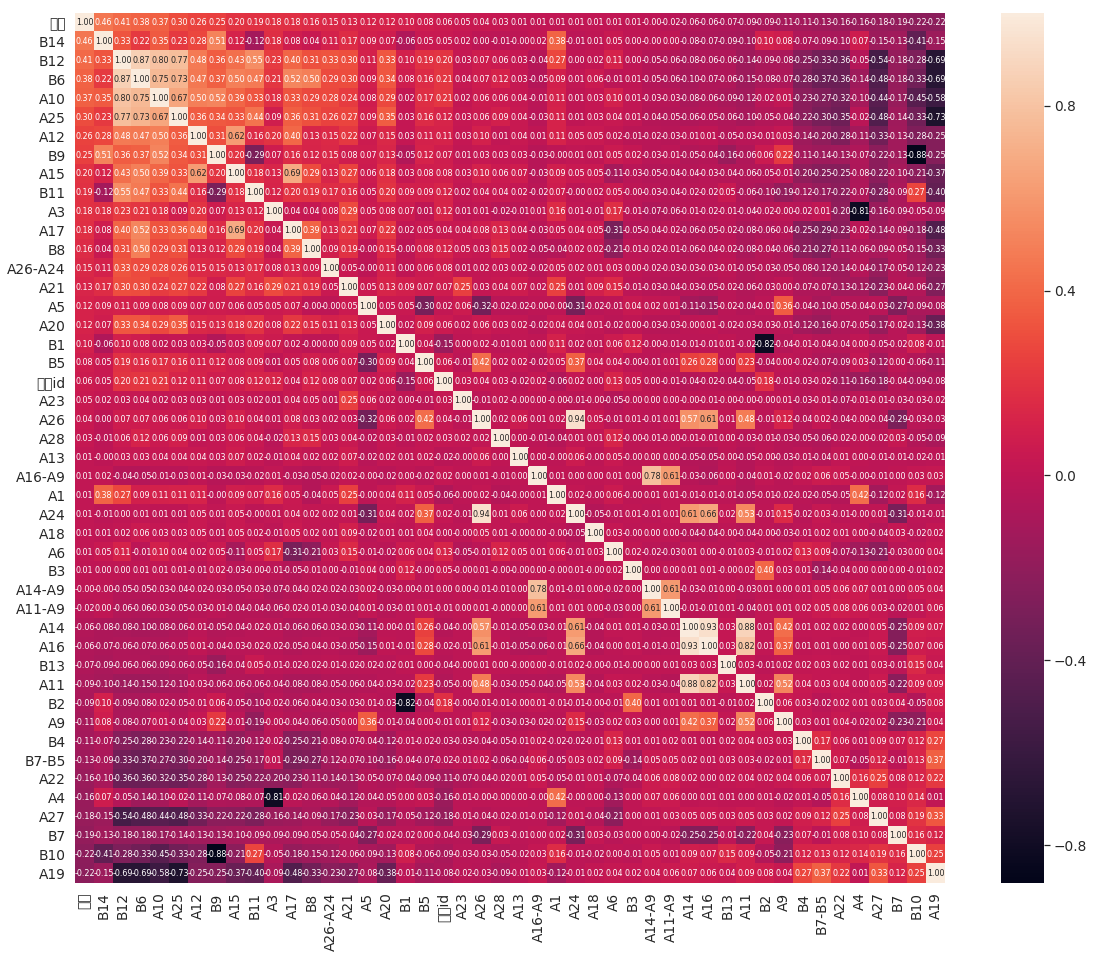

In [90]:
def heatmap(pd_data):
    corrmat = pd_data.corr()
    f, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(corrmat, vmax=.8, square=True)

def heatmap_font(pd_data, k=-1, target=target_name):
    # k is the number of variables for heatmap
    if k == -1:
        k = pd_data.shape[1]
        
    corrmat = pd_data.corr()
    f, ax = plt.subplots(figsize=(20, 16))
    cols = corrmat.nlargest(k, target)[target].index
    cm = np.corrcoef(pd_data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm,
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 8}, 
                     yticklabels=cols.values,
                     xticklabels=cols.values)
    plt.show()
    

    
train_data = data[:train.shape[0]]
train_data[target_name] = target.values
# heatmap(data_map)
print(train_data.shape[1])
heatmap_font(train_data)


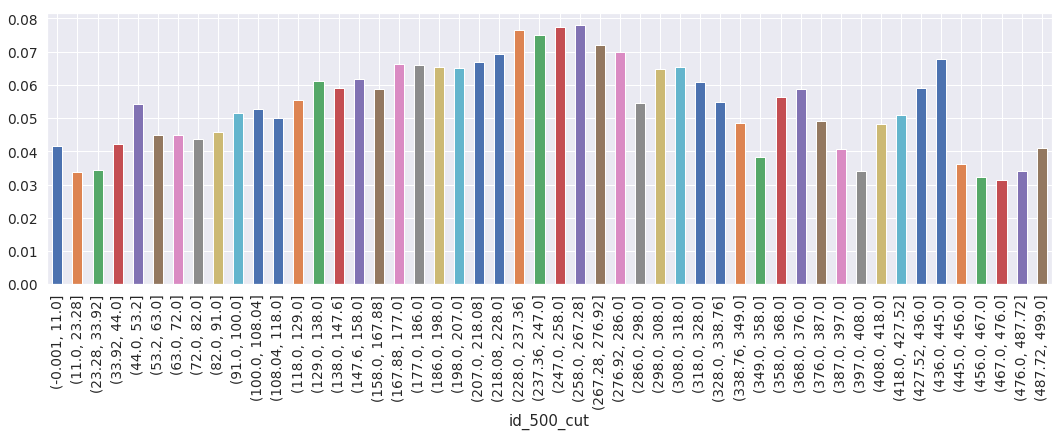

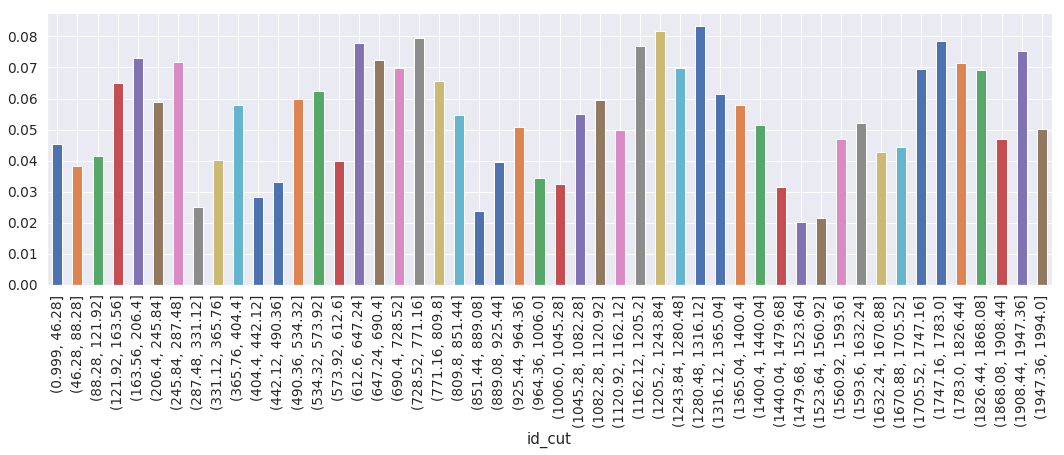

In [124]:
# for col in train_data.columns:
#     print(col)
#     train_data.groupby([])
#     plt.figure(figsize=(3,2))
#     sns.distplot(X_train[..., i], bins=50, kde=False, color="red")
#     # plt.title("Histogram of yield")
#     plt.xlabel(i, fontsize=12)
#     plt.show()
# train_data = train_data.apply(lambda x:round(x, 3), axis=1)

train_data['id_500'] = full['样本id'] % 500
train_data['id_500_cut'] = pd.qcut(train_data['id_500'], 50)
train_data['id_cut'] = pd.qcut(train_data['样本id'], 50)
plt.figure(figsize=(18,5))
(train_data[train_data['收率'] != -1].groupby('id_500_cut')['收率'].mean() - 0.87).plot.bar()
plt.show()
plt.figure(figsize=(18,5))
(train_data[train_data['收率'] != -1].groupby('id_cut')['收率'].mean() - 0.87).plot.bar()
plt.show()

## 删除弱相关特征

In [157]:
def get_idx_by_th(pd_data, threshold):
    corrmat = pd_data.corr()
    cols = corrmat.nlargest(pd_data.shape[1], target_name)[target_name].index
    cm = abs(np.corrcoef(pd_data[cols].values.T))
    chosed_idx = cols[cm[0][0:]>threshold]
    return chosed_idx

chosed_idx = get_idx_by_th(train_data, 0.15)

44
18


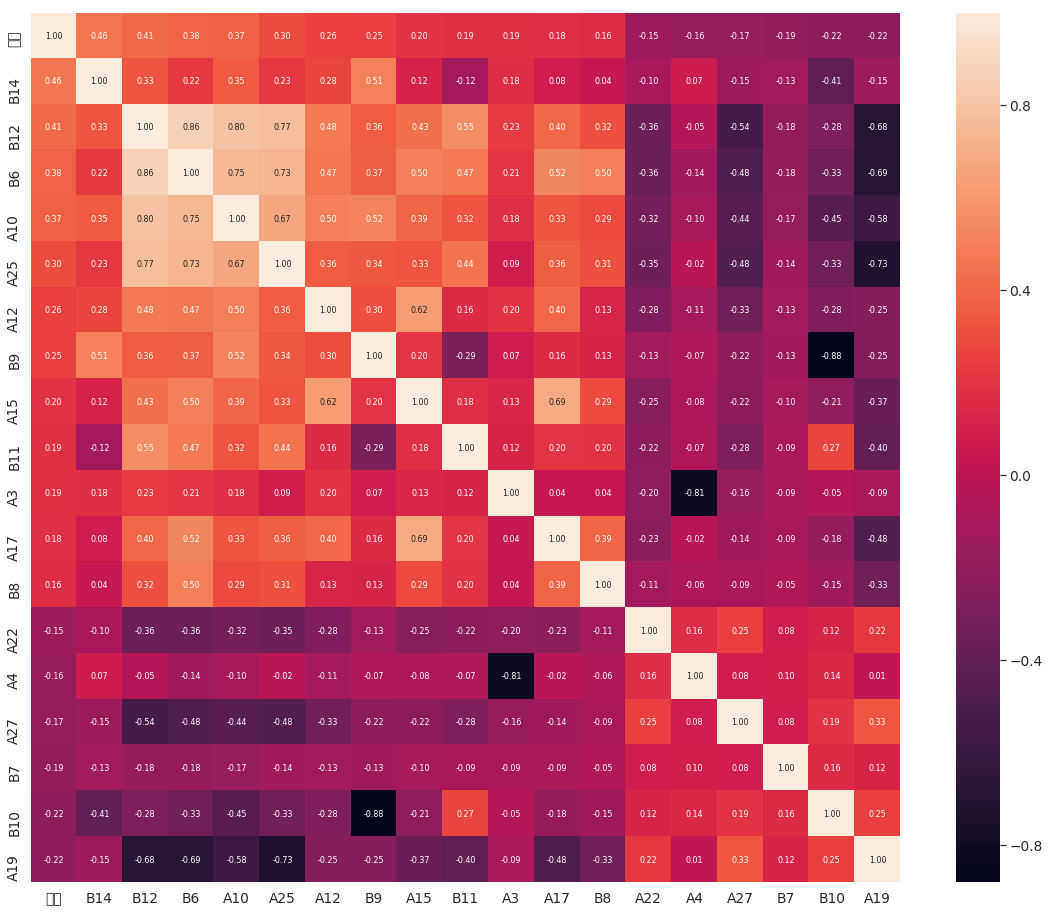

In [158]:
print(data.shape[1])
train_data = train_data[chosed_idx]
data = data[chosed_idx[1:]]
print(data.shape[1])
heatmap_font(train_data)

# 特征处理

In [92]:
X_scaled = data[:train.shape[0]]
y = target

In [94]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled, y)

FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=X_scaled.columns)
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
B10,0.001311
B14,0.000575
A5,0.000424
B11,0.000369
A11,0.000289
A27,0.000246
B6,0.000141
A14,0.000127
B5,0.000085
A24,0.000084


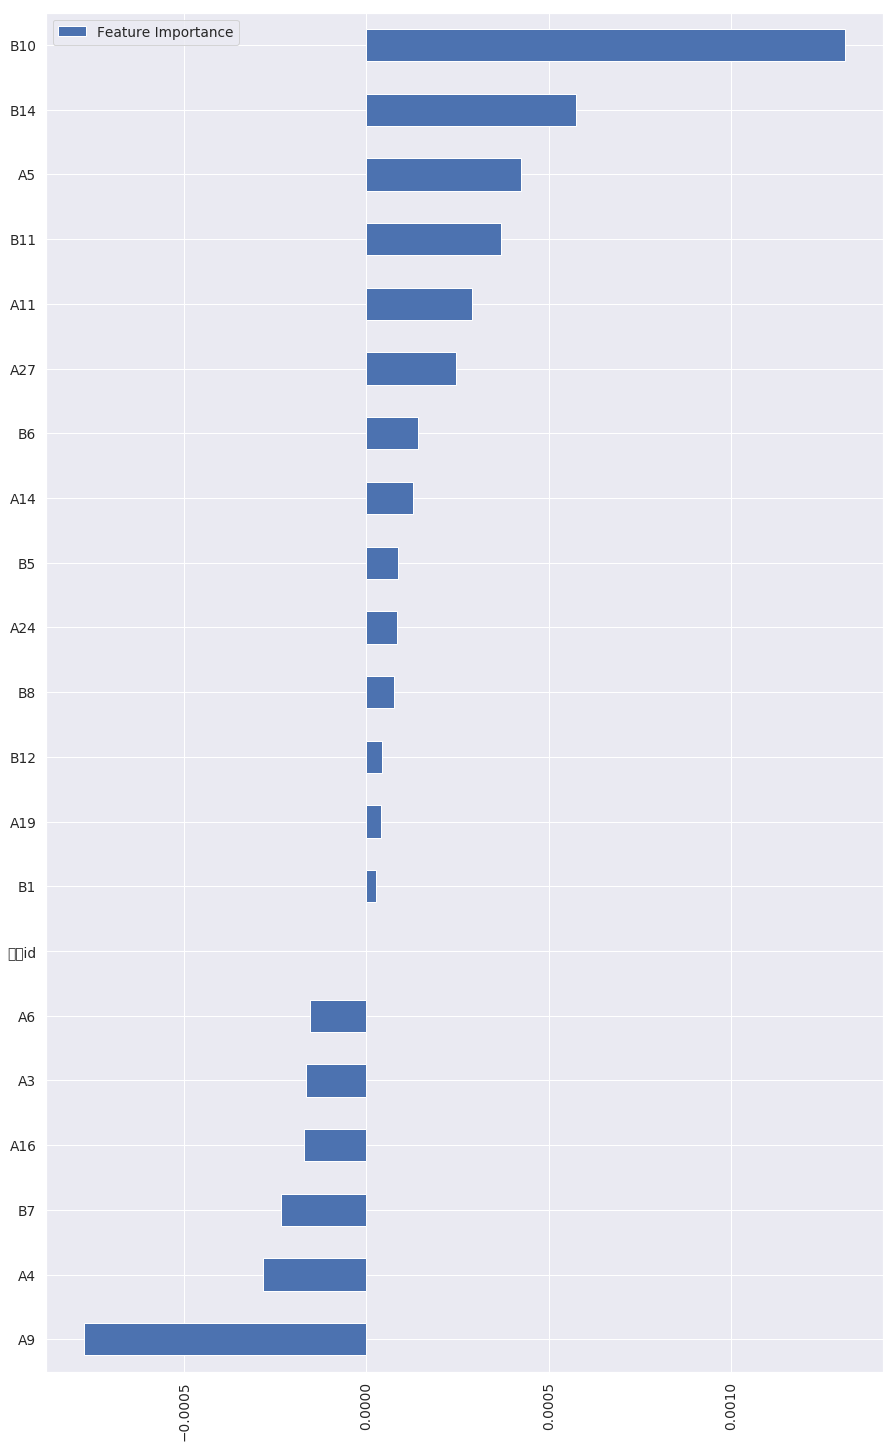

In [95]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

# 训练模型

## 获得训练集与测试集

In [134]:
cate_columns = [f for f in data.columns if f != '样本id']

X_train = data[:train.shape[0]][cate_columns].values.astype(np.float64)
y_train = target.values
X_test = data[train.shape[0]:][cate_columns].values.astype(np.float64)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1381, 15)
(1381,)
(150, 15)


## 多模型测试

In [135]:
def mse_cv(model,X,y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)
    return mse

In [136]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [137]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = mse_cv(model, X_train, y_train)
    print("{}: {:.6f}, {:.4f}".format(name, score.mean(), score.std()))

LR: 0.000555, 0.0001
Ridge: 0.000554, 0.0001
Lasso: 0.000557, 0.0001
RF: 0.000203, 0.0000
GBR: 0.000205, 0.0000
SVR: 0.000942, 0.0000
LinSVR: 0.001771, 0.0020
Ela: 0.000552, 0.0001
SGD: 287955909880546888396667092992.000000, 366313539239121079377772675072.0000
Bay: 0.000552, 0.0001
Ker: 0.000413, 0.0001
Extra: 0.000223, 0.0000
Xgb: 0.000202, 0.0000


## nn

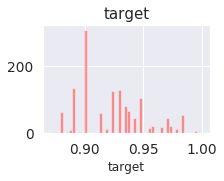

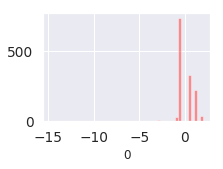

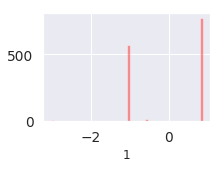

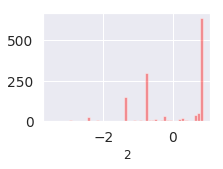

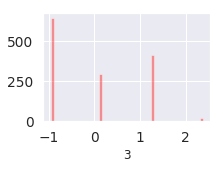

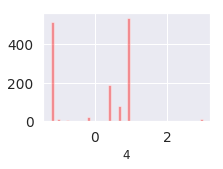

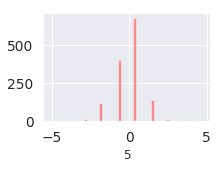

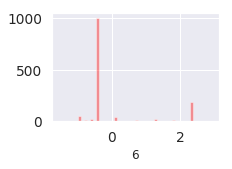

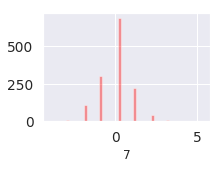

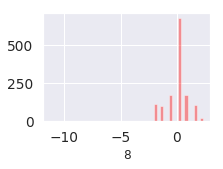

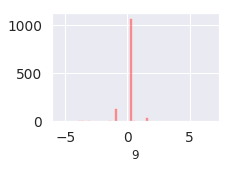

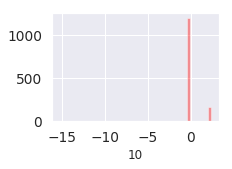

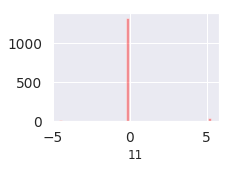

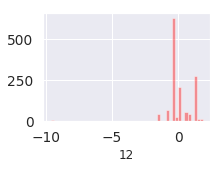

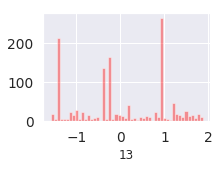

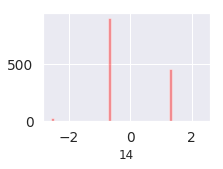

In [138]:
mean = X_train.mean(axis = 0)
X_train -= mean
std = X_train.std(axis = 0)
X_train /= std

X_test -= mean
X_test /= std

# mean = y_train.mean(axis = 0)
# y_train -= mean
# std = y_train.std(axis = 0)
# y_train /= std

plt.figure(figsize=(3,2))
sns.distplot(y_train, bins=50, kde=False, color="red")
plt.title("target")
plt.xlabel("target", fontsize=12)
plt.show()

for i in range(X_train.shape[1]):
    plt.figure(figsize=(3,2))
    sns.distplot(X_train[..., i], bins=50, kde=False, color="red")
    # plt.title("Histogram of yield")
    plt.xlabel(i, fontsize=12)
    plt.show()

In [139]:
import keras
from keras.models import Model
from keras.models import Sequential 
from keras.layers import Dense, Input, add
from keras.layers.core import Dropout, Activation

def dense_block(inp, drop_rate = 0.5):
    x = Dense(100,activation='sigmoid')(inp)
    x = Dropout(drop_rate)(x)
    x = Dense(100,activation='sigmoid')(inp)
    x = Dropout(drop_rate)(x)
    x = Dense(100,activation='sigmoid')(inp)
    x = Dropout(drop_rate)(x)
    x = add([x, inp])

    return x

# model = Sequential()

# model.add(Dense(100, input_shape=(X_train.shape[1],))) # 输入层，26
# model.add(Activation('sigmoid')) # 激活函数是tanh  
# # model.add(Dropout(0.5)) # 采用50%的dropout

# model.add(Dense(100)) # 隐藏层节点500个  
# model.add(Activation('sigmoid'))  
# # model.add(Dropout(0.5))


# model.add(Dense(1)) # 输出结果是10个类别，所以维度是10  

# model.compile(loss='mse', optimizer='adam')
# model.summary()

inpt = Input(shape=(X_train.shape[1],))
x = Dropout(0.8)(inpt)
x = Dense(10,activation='sigmoid')(x)
x = Dense(5,activation='sigmoid')(x)
# x = dense_block(x, drop_rate=1)
# x = dense_block(x, drop_rate=1)
# x = dense_block(x, drop_rate=1)
x = Dense(1)(x)

model = Model(inputs=inpt,outputs=x)
model.compile(loss='mse', optimizer='adam')
model.summary()

'''
   .fit的一些参数
   batch_size：对总的样本数进行分组，每组包含的样本数量
   epochs ：训练次数
   shuffle：是否把数据随机打乱之后再进行训练
   validation_split：拿出百分之多少用来做交叉验证
   verbose：屏显模式 0：不输出  1：输出进度  2：输出每次的训练结果
'''
print('Training -----------')
model.fit(X_train[:1000],
          y_train[:1000],
          batch_size=200,
          epochs=5000,
          shuffle=True,
          verbose=1,
          validation_split=0.3)
    
print("test set")
scores = model.evaluate(X_train[1000:], y_train[1000:], batch_size=200, verbose=1)
print("")
print("The test loss is %f" % scores)
# Y_pred = model.predict(X_train[1000:])
# plt.scatter(range(), y_train[1000:])
# plt.plot(X_train[1000:], Y_pred)
# plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________
Training -----------
Train on 700 samples, validate on 300 samples
Epoch 1/5000
700/700 [==============================] - 0s 287us/step - loss:

700/700 [==============================] - 0s 14us/step - loss: 8.6021e-04 - val_loss: 5.8404e-04
Epoch 145/5000
700/700 [==============================] - 0s 17us/step - loss: 9.3589e-04 - val_loss: 5.8220e-04
Epoch 146/5000
700/700 [==============================] - 0s 19us/step - loss: 9.7939e-04 - val_loss: 5.8114e-04
Epoch 147/5000
700/700 [==============================] - 0s 16us/step - loss: 9.6808e-04 - val_loss: 5.8142e-04
Epoch 148/5000
700/700 [==============================] - 0s 14us/step - loss: 9.3230e-04 - val_loss: 5.8127e-04
Epoch 149/5000
700/700 [==============================] - 0s 16us/step - loss: 8.6787e-04 - val_loss: 5.8160e-04
Epoch 150/5000
700/700 [==============================] - 0s 15us/step - loss: 8.8003e-04 - val_loss: 5.8153e-04
Epoch 151/5000
700/700 [==============================] - 0s 16us/step - loss: 9.0426e-04 - val_loss: 5.8093e-04
Epoch 152/5000
700/700 [==============================] - 0s 14us/step - loss: 0.0010 - val_loss: 5.8094e-04
Ep

700/700 [==============================] - 0s 15us/step - loss: 7.5611e-04 - val_loss: 5.5978e-04
Epoch 289/5000
700/700 [==============================] - 0s 17us/step - loss: 7.5946e-04 - val_loss: 5.5978e-04
Epoch 290/5000
700/700 [==============================] - 0s 16us/step - loss: 6.8808e-04 - val_loss: 5.5864e-04
Epoch 291/5000
700/700 [==============================] - 0s 16us/step - loss: 7.3736e-04 - val_loss: 5.5745e-04
Epoch 292/5000
700/700 [==============================] - 0s 17us/step - loss: 7.5488e-04 - val_loss: 5.5615e-04
Epoch 293/5000
700/700 [==============================] - 0s 17us/step - loss: 7.1741e-04 - val_loss: 5.5565e-04
Epoch 294/5000
700/700 [==============================] - 0s 16us/step - loss: 7.8117e-04 - val_loss: 5.5474e-04
Epoch 295/5000
700/700 [==============================] - 0s 16us/step - loss: 7.4751e-04 - val_loss: 5.5482e-04
Epoch 296/5000
700/700 [==============================] - 0s 17us/step - loss: 7.2127e-04 - val_loss: 5.5641e-0

700/700 [==============================] - 0s 15us/step - loss: 6.9318e-04 - val_loss: 5.3437e-04
Epoch 433/5000
700/700 [==============================] - 0s 16us/step - loss: 6.8684e-04 - val_loss: 5.3502e-04
Epoch 434/5000
700/700 [==============================] - 0s 16us/step - loss: 7.1476e-04 - val_loss: 5.3665e-04
Epoch 435/5000
700/700 [==============================] - 0s 18us/step - loss: 6.8897e-04 - val_loss: 5.3796e-04
Epoch 436/5000
700/700 [==============================] - 0s 16us/step - loss: 7.0045e-04 - val_loss: 5.3973e-04
Epoch 437/5000
700/700 [==============================] - 0s 16us/step - loss: 7.1185e-04 - val_loss: 5.4052e-04
Epoch 438/5000
700/700 [==============================] - 0s 16us/step - loss: 6.7998e-04 - val_loss: 5.4162e-04
Epoch 439/5000
700/700 [==============================] - 0s 17us/step - loss: 7.2117e-04 - val_loss: 5.4334e-04
Epoch 440/5000
700/700 [==============================] - 0s 16us/step - loss: 6.8070e-04 - val_loss: 5.4529e-0

700/700 [==============================] - 0s 16us/step - loss: 6.8030e-04 - val_loss: 5.3964e-04
Epoch 577/5000
700/700 [==============================] - 0s 16us/step - loss: 6.7638e-04 - val_loss: 5.4159e-04
Epoch 578/5000
700/700 [==============================] - 0s 16us/step - loss: 6.8085e-04 - val_loss: 5.4401e-04
Epoch 579/5000
700/700 [==============================] - 0s 14us/step - loss: 6.4714e-04 - val_loss: 5.4486e-04
Epoch 580/5000
700/700 [==============================] - 0s 14us/step - loss: 6.8784e-04 - val_loss: 5.4573e-04
Epoch 581/5000
700/700 [==============================] - 0s 16us/step - loss: 6.5264e-04 - val_loss: 5.4666e-04
Epoch 582/5000
700/700 [==============================] - 0s 15us/step - loss: 6.5721e-04 - val_loss: 5.4658e-04
Epoch 583/5000
700/700 [==============================] - 0s 19us/step - loss: 6.5845e-04 - val_loss: 5.4577e-04
Epoch 584/5000
700/700 [==============================] - 0s 18us/step - loss: 6.3526e-04 - val_loss: 5.4467e-0

700/700 [==============================] - 0s 18us/step - loss: 6.1921e-04 - val_loss: 5.2286e-04
Epoch 721/5000
700/700 [==============================] - 0s 15us/step - loss: 6.0662e-04 - val_loss: 5.2174e-04
Epoch 722/5000
700/700 [==============================] - 0s 15us/step - loss: 6.5128e-04 - val_loss: 5.2067e-04
Epoch 723/5000
700/700 [==============================] - 0s 18us/step - loss: 6.5752e-04 - val_loss: 5.1990e-04
Epoch 724/5000
700/700 [==============================] - 0s 15us/step - loss: 6.5740e-04 - val_loss: 5.2041e-04
Epoch 725/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2278e-04 - val_loss: 5.2231e-04
Epoch 726/5000
700/700 [==============================] - 0s 16us/step - loss: 6.4814e-04 - val_loss: 5.2397e-04
Epoch 727/5000
700/700 [==============================] - 0s 18us/step - loss: 6.6311e-04 - val_loss: 5.2487e-04
Epoch 728/5000
700/700 [==============================] - 0s 15us/step - loss: 6.3192e-04 - val_loss: 5.2517e-0

700/700 [==============================] - 0s 20us/step - loss: 6.3534e-04 - val_loss: 5.2410e-04
Epoch 865/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2070e-04 - val_loss: 5.2109e-04
Epoch 866/5000
700/700 [==============================] - 0s 18us/step - loss: 6.3906e-04 - val_loss: 5.1918e-04
Epoch 867/5000
700/700 [==============================] - 0s 22us/step - loss: 6.2775e-04 - val_loss: 5.1783e-04
Epoch 868/5000
700/700 [==============================] - 0s 20us/step - loss: 6.3921e-04 - val_loss: 5.1840e-04
Epoch 869/5000
700/700 [==============================] - 0s 19us/step - loss: 6.3991e-04 - val_loss: 5.1950e-04
Epoch 870/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2241e-04 - val_loss: 5.1890e-04
Epoch 871/5000
700/700 [==============================] - 0s 18us/step - loss: 6.4851e-04 - val_loss: 5.1913e-04
Epoch 872/5000
700/700 [==============================] - 0s 22us/step - loss: 6.5564e-04 - val_loss: 5.2119e-0

700/700 [==============================] - 0s 15us/step - loss: 6.3806e-04 - val_loss: 5.1986e-04
Epoch 1009/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2688e-04 - val_loss: 5.1628e-04
Epoch 1010/5000
700/700 [==============================] - 0s 18us/step - loss: 6.4071e-04 - val_loss: 5.1686e-04
Epoch 1011/5000
700/700 [==============================] - 0s 17us/step - loss: 6.4769e-04 - val_loss: 5.1657e-04
Epoch 1012/5000
700/700 [==============================] - 0s 24us/step - loss: 6.6009e-04 - val_loss: 5.1710e-04
Epoch 1013/5000
700/700 [==============================] - 0s 20us/step - loss: 6.3155e-04 - val_loss: 5.1804e-04
Epoch 1014/5000
700/700 [==============================] - 0s 20us/step - loss: 6.4819e-04 - val_loss: 5.1804e-04
Epoch 1015/5000
700/700 [==============================] - 0s 16us/step - loss: 6.5088e-04 - val_loss: 5.1831e-04
Epoch 1016/5000
700/700 [==============================] - 0s 18us/step - loss: 6.5560e-04 - val_loss: 5

700/700 [==============================] - 0s 15us/step - loss: 6.0698e-04 - val_loss: 5.1309e-04
Epoch 1081/5000
700/700 [==============================] - 0s 19us/step - loss: 6.4173e-04 - val_loss: 5.1420e-04
Epoch 1082/5000
700/700 [==============================] - 0s 20us/step - loss: 6.6143e-04 - val_loss: 5.1816e-04
Epoch 1083/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2016e-04 - val_loss: 5.1821e-04
Epoch 1084/5000
700/700 [==============================] - 0s 20us/step - loss: 6.5129e-04 - val_loss: 5.1291e-04
Epoch 1085/5000
700/700 [==============================] - 0s 17us/step - loss: 6.4395e-04 - val_loss: 5.1211e-04
Epoch 1086/5000
700/700 [==============================] - 0s 15us/step - loss: 6.2727e-04 - val_loss: 5.1282e-04
Epoch 1087/5000
700/700 [==============================] - 0s 14us/step - loss: 6.2639e-04 - val_loss: 5.1449e-04
Epoch 1088/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2789e-04 - val_loss: 5

700/700 [==============================] - 0s 19us/step - loss: 6.1769e-04 - val_loss: 5.0710e-04
Epoch 1153/5000
700/700 [==============================] - 0s 20us/step - loss: 6.4980e-04 - val_loss: 5.0696e-04
Epoch 1154/5000
700/700 [==============================] - 0s 20us/step - loss: 6.2888e-04 - val_loss: 5.0877e-04
Epoch 1155/5000
700/700 [==============================] - 0s 15us/step - loss: 6.3086e-04 - val_loss: 5.1364e-04
Epoch 1156/5000
700/700 [==============================] - 0s 19us/step - loss: 6.7598e-04 - val_loss: 5.1996e-04
Epoch 1157/5000
700/700 [==============================] - 0s 19us/step - loss: 6.2925e-04 - val_loss: 5.1678e-04
Epoch 1158/5000
700/700 [==============================] - 0s 21us/step - loss: 6.4119e-04 - val_loss: 5.2232e-04
Epoch 1159/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2534e-04 - val_loss: 5.1954e-04
Epoch 1160/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1010e-04 - val_loss: 5

700/700 [==============================] - 0s 19us/step - loss: 6.5395e-04 - val_loss: 5.1214e-04
Epoch 1225/5000
700/700 [==============================] - 0s 19us/step - loss: 6.3468e-04 - val_loss: 5.1335e-04
Epoch 1226/5000
700/700 [==============================] - 0s 15us/step - loss: 6.3073e-04 - val_loss: 5.1412e-04
Epoch 1227/5000
700/700 [==============================] - 0s 21us/step - loss: 5.9949e-04 - val_loss: 5.1289e-04
Epoch 1228/5000
700/700 [==============================] - 0s 22us/step - loss: 6.3998e-04 - val_loss: 5.0837e-04
Epoch 1229/5000
700/700 [==============================] - 0s 22us/step - loss: 6.7054e-04 - val_loss: 5.0761e-04
Epoch 1230/5000
700/700 [==============================] - 0s 26us/step - loss: 6.2312e-04 - val_loss: 5.0476e-04
Epoch 1231/5000
700/700 [==============================] - 0s 22us/step - loss: 6.6385e-04 - val_loss: 5.0641e-04
Epoch 1232/5000
700/700 [==============================] - 0s 22us/step - loss: 6.1101e-04 - val_loss: 5

700/700 [==============================] - 0s 17us/step - loss: 6.2845e-04 - val_loss: 5.1356e-04
Epoch 1297/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2707e-04 - val_loss: 5.0840e-04
Epoch 1298/5000
700/700 [==============================] - 0s 23us/step - loss: 6.3993e-04 - val_loss: 5.1086e-04
Epoch 1299/5000
700/700 [==============================] - 0s 19us/step - loss: 6.4947e-04 - val_loss: 5.1789e-04
Epoch 1300/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1068e-04 - val_loss: 5.0360e-04
Epoch 1301/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1531e-04 - val_loss: 5.0096e-04
Epoch 1302/5000
700/700 [==============================] - 0s 15us/step - loss: 6.3995e-04 - val_loss: 5.0242e-04
Epoch 1303/5000
700/700 [==============================] - 0s 20us/step - loss: 6.2124e-04 - val_loss: 5.0855e-04
Epoch 1304/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1456e-04 - val_loss: 5

700/700 [==============================] - 0s 18us/step - loss: 6.1974e-04 - val_loss: 5.0355e-04
Epoch 1369/5000
700/700 [==============================] - 0s 15us/step - loss: 6.0114e-04 - val_loss: 5.0518e-04
Epoch 1370/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1011e-04 - val_loss: 4.9654e-04
Epoch 1371/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2171e-04 - val_loss: 4.9753e-04
Epoch 1372/5000
700/700 [==============================] - 0s 22us/step - loss: 6.5049e-04 - val_loss: 5.0555e-04
Epoch 1373/5000
700/700 [==============================] - 0s 19us/step - loss: 6.7037e-04 - val_loss: 5.0753e-04
Epoch 1374/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2852e-04 - val_loss: 5.0538e-04
Epoch 1375/5000
700/700 [==============================] - 0s 21us/step - loss: 6.1870e-04 - val_loss: 5.0836e-04
Epoch 1376/5000
700/700 [==============================] - 0s 20us/step - loss: 6.3878e-04 - val_loss: 5

700/700 [==============================] - 0s 19us/step - loss: 6.4968e-04 - val_loss: 5.0672e-04
Epoch 1441/5000
700/700 [==============================] - 0s 13us/step - loss: 6.5574e-04 - val_loss: 5.1690e-04
Epoch 1442/5000
700/700 [==============================] - 0s 16us/step - loss: 5.9161e-04 - val_loss: 5.0347e-04
Epoch 1443/5000
700/700 [==============================] - 0s 14us/step - loss: 6.6254e-04 - val_loss: 5.0015e-04
Epoch 1444/5000
700/700 [==============================] - 0s 14us/step - loss: 6.4606e-04 - val_loss: 5.0036e-04
Epoch 1445/5000
700/700 [==============================] - 0s 14us/step - loss: 6.4799e-04 - val_loss: 5.0556e-04
Epoch 1446/5000
700/700 [==============================] - 0s 12us/step - loss: 6.1396e-04 - val_loss: 5.0379e-04
Epoch 1447/5000
700/700 [==============================] - 0s 11us/step - loss: 6.4538e-04 - val_loss: 5.0118e-04
Epoch 1448/5000
700/700 [==============================] - 0s 11us/step - loss: 6.3866e-04 - val_loss: 5

700/700 [==============================] - 0s 16us/step - loss: 6.4194e-04 - val_loss: 4.9469e-04
Epoch 1513/5000
700/700 [==============================] - 0s 15us/step - loss: 6.5136e-04 - val_loss: 4.9855e-04
Epoch 1514/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2844e-04 - val_loss: 5.0897e-04
Epoch 1515/5000
700/700 [==============================] - 0s 16us/step - loss: 5.9984e-04 - val_loss: 5.1015e-04
Epoch 1516/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1597e-04 - val_loss: 5.0794e-04
Epoch 1517/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2116e-04 - val_loss: 5.0998e-04
Epoch 1518/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1286e-04 - val_loss: 5.2009e-04
Epoch 1519/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2287e-04 - val_loss: 5.0817e-04
Epoch 1520/5000
700/700 [==============================] - 0s 14us/step - loss: 6.0026e-04 - val_loss: 5

700/700 [==============================] - 0s 19us/step - loss: 6.5300e-04 - val_loss: 4.9843e-04
Epoch 1585/5000
700/700 [==============================] - 0s 16us/step - loss: 6.4001e-04 - val_loss: 5.0274e-04
Epoch 1586/5000
700/700 [==============================] - 0s 23us/step - loss: 6.4096e-04 - val_loss: 5.1018e-04
Epoch 1587/5000
700/700 [==============================] - 0s 22us/step - loss: 6.7750e-04 - val_loss: 5.0765e-04
Epoch 1588/5000
700/700 [==============================] - 0s 20us/step - loss: 6.3637e-04 - val_loss: 5.0960e-04
Epoch 1589/5000
700/700 [==============================] - 0s 17us/step - loss: 6.3218e-04 - val_loss: 5.1421e-04
Epoch 1590/5000
700/700 [==============================] - 0s 21us/step - loss: 6.3853e-04 - val_loss: 5.0815e-04
Epoch 1591/5000
700/700 [==============================] - 0s 21us/step - loss: 6.1578e-04 - val_loss: 5.0070e-04
Epoch 1592/5000
700/700 [==============================] - 0s 19us/step - loss: 6.1770e-04 - val_loss: 5

Epoch 1728/5000
700/700 [==============================] - 0s 18us/step - loss: 6.4728e-04 - val_loss: 5.0427e-04
Epoch 1729/5000
700/700 [==============================] - 0s 21us/step - loss: 6.1609e-04 - val_loss: 5.1219e-04
Epoch 1730/5000
700/700 [==============================] - 0s 20us/step - loss: 6.4363e-04 - val_loss: 5.0611e-04
Epoch 1731/5000
700/700 [==============================] - 0s 15us/step - loss: 6.0663e-04 - val_loss: 5.0424e-04
Epoch 1732/5000
700/700 [==============================] - 0s 20us/step - loss: 6.4450e-04 - val_loss: 4.9978e-04
Epoch 1733/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2062e-04 - val_loss: 5.0052e-04
Epoch 1734/5000
700/700 [==============================] - 0s 17us/step - loss: 6.3516e-04 - val_loss: 4.9526e-04
Epoch 1735/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1770e-04 - val_loss: 4.9681e-04
Epoch 1736/5000
700/700 [==============================] - 0s 14us/step - loss: 6.4671e-

Epoch 1800/5000
700/700 [==============================] - 0s 19us/step - loss: 5.9507e-04 - val_loss: 4.9285e-04
Epoch 1801/5000
700/700 [==============================] - 0s 20us/step - loss: 6.2123e-04 - val_loss: 4.9570e-04
Epoch 1802/5000
700/700 [==============================] - 0s 19us/step - loss: 6.4797e-04 - val_loss: 4.8949e-04
Epoch 1803/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1679e-04 - val_loss: 4.9776e-04
Epoch 1804/5000
700/700 [==============================] - 0s 16us/step - loss: 6.4714e-04 - val_loss: 4.8955e-04
Epoch 1805/5000
700/700 [==============================] - 0s 18us/step - loss: 6.3714e-04 - val_loss: 4.9267e-04
Epoch 1806/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2909e-04 - val_loss: 5.0543e-04
Epoch 1807/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2927e-04 - val_loss: 4.9381e-04
Epoch 1808/5000
700/700 [==============================] - 0s 15us/step - loss: 6.2083e-

Epoch 1872/5000
700/700 [==============================] - 0s 19us/step - loss: 6.3545e-04 - val_loss: 4.9802e-04
Epoch 1873/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2946e-04 - val_loss: 5.0290e-04
Epoch 1874/5000
700/700 [==============================] - 0s 21us/step - loss: 6.4102e-04 - val_loss: 4.9735e-04
Epoch 1875/5000
700/700 [==============================] - 0s 23us/step - loss: 6.3515e-04 - val_loss: 5.0898e-04
Epoch 1876/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0666e-04 - val_loss: 5.0302e-04
Epoch 1877/5000
700/700 [==============================] - 0s 22us/step - loss: 6.2474e-04 - val_loss: 4.9769e-04
Epoch 1878/5000
700/700 [==============================] - 0s 21us/step - loss: 6.1541e-04 - val_loss: 5.1182e-04
Epoch 1879/5000
700/700 [==============================] - 0s 23us/step - loss: 6.3405e-04 - val_loss: 5.0568e-04
Epoch 1880/5000
700/700 [==============================] - 0s 22us/step - loss: 5.9721e-

Epoch 1944/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2883e-04 - val_loss: 4.9297e-04
Epoch 1945/5000
700/700 [==============================] - 0s 21us/step - loss: 6.1116e-04 - val_loss: 4.9248e-04
Epoch 1946/5000
700/700 [==============================] - 0s 22us/step - loss: 6.0586e-04 - val_loss: 4.9112e-04
Epoch 1947/5000
700/700 [==============================] - 0s 21us/step - loss: 6.5216e-04 - val_loss: 4.8949e-04
Epoch 1948/5000
700/700 [==============================] - 0s 20us/step - loss: 6.2406e-04 - val_loss: 4.8842e-04
Epoch 1949/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1844e-04 - val_loss: 4.8978e-04
Epoch 1950/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2924e-04 - val_loss: 4.8405e-04
Epoch 1951/5000
700/700 [==============================] - 0s 20us/step - loss: 6.2512e-04 - val_loss: 4.8330e-04
Epoch 1952/5000
700/700 [==============================] - 0s 21us/step - loss: 6.1528e-

Epoch 2016/5000
700/700 [==============================] - 0s 21us/step - loss: 5.9682e-04 - val_loss: 4.9927e-04
Epoch 2017/5000
700/700 [==============================] - 0s 13us/step - loss: 6.1191e-04 - val_loss: 5.0170e-04
Epoch 2018/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0259e-04 - val_loss: 5.0498e-04
Epoch 2019/5000
700/700 [==============================] - 0s 22us/step - loss: 5.8532e-04 - val_loss: 4.9611e-04
Epoch 2020/5000
700/700 [==============================] - 0s 20us/step - loss: 6.3481e-04 - val_loss: 4.8798e-04
Epoch 2021/5000
700/700 [==============================] - 0s 22us/step - loss: 6.4287e-04 - val_loss: 4.9230e-04
Epoch 2022/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2457e-04 - val_loss: 4.8917e-04
Epoch 2023/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1760e-04 - val_loss: 4.8733e-04
Epoch 2024/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1379e-

Epoch 2088/5000
700/700 [==============================] - 0s 17us/step - loss: 6.4567e-04 - val_loss: 4.6708e-04
Epoch 2089/5000
700/700 [==============================] - 0s 20us/step - loss: 6.4239e-04 - val_loss: 4.7999e-04
Epoch 2090/5000
700/700 [==============================] - 0s 16us/step - loss: 6.4651e-04 - val_loss: 4.7377e-04
Epoch 2091/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1413e-04 - val_loss: 4.7847e-04
Epoch 2092/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2127e-04 - val_loss: 4.9765e-04
Epoch 2093/5000
700/700 [==============================] - 0s 22us/step - loss: 6.3955e-04 - val_loss: 4.8426e-04
Epoch 2094/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2232e-04 - val_loss: 4.8614e-04
Epoch 2095/5000
700/700 [==============================] - 0s 20us/step - loss: 6.0487e-04 - val_loss: 5.0273e-04
Epoch 2096/5000
700/700 [==============================] - 0s 22us/step - loss: 6.3300e-

Epoch 2160/5000
700/700 [==============================] - 0s 18us/step - loss: 6.3021e-04 - val_loss: 4.8735e-04
Epoch 2161/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1926e-04 - val_loss: 5.0547e-04
Epoch 2162/5000
700/700 [==============================] - 0s 18us/step - loss: 6.4684e-04 - val_loss: 4.9146e-04
Epoch 2163/5000
700/700 [==============================] - 0s 18us/step - loss: 6.3563e-04 - val_loss: 4.9709e-04
Epoch 2164/5000
700/700 [==============================] - 0s 17us/step - loss: 6.3503e-04 - val_loss: 4.9692e-04
Epoch 2165/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1723e-04 - val_loss: 4.9957e-04
Epoch 2166/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2992e-04 - val_loss: 4.9585e-04
Epoch 2167/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1110e-04 - val_loss: 4.9413e-04
Epoch 2168/5000
700/700 [==============================] - 0s 16us/step - loss: 5.9214e-

Epoch 2232/5000
700/700 [==============================] - 0s 18us/step - loss: 6.3453e-04 - val_loss: 4.8702e-04
Epoch 2233/5000
700/700 [==============================] - 0s 13us/step - loss: 6.2516e-04 - val_loss: 4.8709e-04
Epoch 2234/5000
700/700 [==============================] - 0s 20us/step - loss: 6.0317e-04 - val_loss: 4.9556e-04
Epoch 2235/5000
700/700 [==============================] - 0s 20us/step - loss: 6.0889e-04 - val_loss: 4.8782e-04
Epoch 2236/5000
700/700 [==============================] - 0s 21us/step - loss: 6.0655e-04 - val_loss: 4.8583e-04
Epoch 2237/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2064e-04 - val_loss: 4.8828e-04
Epoch 2238/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2393e-04 - val_loss: 4.9949e-04
Epoch 2239/5000
700/700 [==============================] - 0s 19us/step - loss: 6.4473e-04 - val_loss: 4.9463e-04
Epoch 2240/5000
700/700 [==============================] - 0s 20us/step - loss: 6.0409e-

Epoch 2304/5000
700/700 [==============================] - 0s 21us/step - loss: 6.3417e-04 - val_loss: 4.8640e-04
Epoch 2305/5000
700/700 [==============================] - 0s 22us/step - loss: 6.3941e-04 - val_loss: 4.8761e-04
Epoch 2306/5000
700/700 [==============================] - 0s 14us/step - loss: 6.0993e-04 - val_loss: 4.9878e-04
Epoch 2307/5000
700/700 [==============================] - 0s 19us/step - loss: 6.4132e-04 - val_loss: 4.8729e-04
Epoch 2308/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1380e-04 - val_loss: 4.8729e-04
Epoch 2309/5000
700/700 [==============================] - 0s 15us/step - loss: 6.1372e-04 - val_loss: 4.9406e-04
Epoch 2310/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1298e-04 - val_loss: 4.8773e-04
Epoch 2311/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1803e-04 - val_loss: 4.9133e-04
Epoch 2312/5000
700/700 [==============================] - 0s 20us/step - loss: 6.3533e-

Epoch 2376/5000
700/700 [==============================] - 0s 25us/step - loss: 6.2408e-04 - val_loss: 4.7955e-04
Epoch 2377/5000
700/700 [==============================] - 0s 17us/step - loss: 6.4381e-04 - val_loss: 4.7827e-04
Epoch 2378/5000
700/700 [==============================] - 0s 20us/step - loss: 6.3697e-04 - val_loss: 5.0093e-04
Epoch 2379/5000
700/700 [==============================] - 0s 20us/step - loss: 6.4707e-04 - val_loss: 4.8105e-04
Epoch 2380/5000
700/700 [==============================] - 0s 15us/step - loss: 6.0533e-04 - val_loss: 4.8774e-04
Epoch 2381/5000
700/700 [==============================] - 0s 17us/step - loss: 6.3183e-04 - val_loss: 4.9264e-04
Epoch 2382/5000
700/700 [==============================] - 0s 18us/step - loss: 6.0986e-04 - val_loss: 4.8434e-04
Epoch 2383/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1425e-04 - val_loss: 4.8022e-04
Epoch 2384/5000
700/700 [==============================] - 0s 16us/step - loss: 6.0282e-

Epoch 2448/5000
700/700 [==============================] - 0s 16us/step - loss: 6.4242e-04 - val_loss: 4.8458e-04
Epoch 2449/5000
700/700 [==============================] - 0s 20us/step - loss: 6.2572e-04 - val_loss: 4.8442e-04
Epoch 2450/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1352e-04 - val_loss: 4.8239e-04
Epoch 2451/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1446e-04 - val_loss: 4.8593e-04
Epoch 2452/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1555e-04 - val_loss: 4.8820e-04
Epoch 2453/5000
700/700 [==============================] - 0s 15us/step - loss: 6.0876e-04 - val_loss: 4.8660e-04
Epoch 2454/5000
700/700 [==============================] - 0s 18us/step - loss: 6.3719e-04 - val_loss: 4.9107e-04
Epoch 2455/5000
700/700 [==============================] - 0s 18us/step - loss: 6.5009e-04 - val_loss: 4.8915e-04
Epoch 2456/5000
700/700 [==============================] - 0s 19us/step - loss: 6.2516e-

Epoch 2520/5000
700/700 [==============================] - 0s 14us/step - loss: 6.1207e-04 - val_loss: 4.7698e-04
Epoch 2521/5000
700/700 [==============================] - 0s 23us/step - loss: 6.1707e-04 - val_loss: 4.8145e-04
Epoch 2522/5000
700/700 [==============================] - 0s 21us/step - loss: 6.1978e-04 - val_loss: 4.8920e-04
Epoch 2523/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0855e-04 - val_loss: 4.9994e-04
Epoch 2524/5000
700/700 [==============================] - 0s 19us/step - loss: 5.9881e-04 - val_loss: 4.8745e-04
Epoch 2525/5000
700/700 [==============================] - 0s 18us/step - loss: 6.0545e-04 - val_loss: 4.7868e-04
Epoch 2526/5000
700/700 [==============================] - 0s 16us/step - loss: 6.2494e-04 - val_loss: 4.8126e-04
Epoch 2527/5000
700/700 [==============================] - 0s 15us/step - loss: 6.0338e-04 - val_loss: 4.6707e-04
Epoch 2528/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1583e-

Epoch 2592/5000
700/700 [==============================] - 0s 16us/step - loss: 6.3855e-04 - val_loss: 4.8248e-04
Epoch 2593/5000
700/700 [==============================] - 0s 17us/step - loss: 6.3271e-04 - val_loss: 4.8152e-04
Epoch 2594/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0476e-04 - val_loss: 4.9146e-04
Epoch 2595/5000
700/700 [==============================] - 0s 16us/step - loss: 6.2566e-04 - val_loss: 4.8223e-04
Epoch 2596/5000
700/700 [==============================] - 0s 15us/step - loss: 6.2830e-04 - val_loss: 4.8581e-04
Epoch 2597/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1474e-04 - val_loss: 4.8679e-04
Epoch 2598/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0786e-04 - val_loss: 4.8300e-04
Epoch 2599/5000
700/700 [==============================] - 0s 15us/step - loss: 6.3310e-04 - val_loss: 4.8524e-04
Epoch 2600/5000
700/700 [==============================] - 0s 18us/step - loss: 6.0714e-

Epoch 2664/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1307e-04 - val_loss: 4.7902e-04
Epoch 2665/5000
700/700 [==============================] - 0s 19us/step - loss: 6.2871e-04 - val_loss: 4.8567e-04
Epoch 2666/5000
700/700 [==============================] - 0s 15us/step - loss: 6.1257e-04 - val_loss: 4.7795e-04
Epoch 2667/5000
700/700 [==============================] - 0s 20us/step - loss: 5.7984e-04 - val_loss: 4.8204e-04
Epoch 2668/5000
700/700 [==============================] - 0s 19us/step - loss: 5.9235e-04 - val_loss: 4.7880e-04
Epoch 2669/5000
700/700 [==============================] - 0s 20us/step - loss: 5.9934e-04 - val_loss: 4.8902e-04
Epoch 2670/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0885e-04 - val_loss: 4.7482e-04
Epoch 2671/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1921e-04 - val_loss: 4.7350e-04
Epoch 2672/5000
700/700 [==============================] - 0s 17us/step - loss: 6.4376e-

Epoch 2736/5000
700/700 [==============================] - 0s 23us/step - loss: 6.0805e-04 - val_loss: 4.7628e-04
Epoch 2737/5000
700/700 [==============================] - 0s 20us/step - loss: 6.2293e-04 - val_loss: 4.7575e-04
Epoch 2738/5000
700/700 [==============================] - 0s 20us/step - loss: 6.0122e-04 - val_loss: 4.7829e-04
Epoch 2739/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1797e-04 - val_loss: 4.8359e-04
Epoch 2740/5000
700/700 [==============================] - 0s 28us/step - loss: 6.2617e-04 - val_loss: 4.8626e-04
Epoch 2741/5000
700/700 [==============================] - 0s 25us/step - loss: 6.3274e-04 - val_loss: 4.8246e-04
Epoch 2742/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1470e-04 - val_loss: 4.8048e-04
Epoch 2743/5000
700/700 [==============================] - 0s 19us/step - loss: 6.2118e-04 - val_loss: 4.9022e-04
Epoch 2744/5000
700/700 [==============================] - 0s 22us/step - loss: 6.1116e-

Epoch 2808/5000
700/700 [==============================] - 0s 16us/step - loss: 6.4019e-04 - val_loss: 4.7529e-04
Epoch 2809/5000
700/700 [==============================] - 0s 22us/step - loss: 6.0306e-04 - val_loss: 4.7732e-04
Epoch 2810/5000
700/700 [==============================] - 0s 22us/step - loss: 6.0327e-04 - val_loss: 4.7577e-04
Epoch 2811/5000
700/700 [==============================] - 0s 22us/step - loss: 6.1306e-04 - val_loss: 4.7981e-04
Epoch 2812/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2586e-04 - val_loss: 4.7834e-04
Epoch 2813/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0341e-04 - val_loss: 4.8362e-04
Epoch 2814/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0188e-04 - val_loss: 4.8939e-04
Epoch 2815/5000
700/700 [==============================] - 0s 22us/step - loss: 6.0069e-04 - val_loss: 4.7636e-04
Epoch 2816/5000
700/700 [==============================] - 0s 23us/step - loss: 6.0935e-

Epoch 2880/5000
700/700 [==============================] - 0s 13us/step - loss: 6.0852e-04 - val_loss: 4.8434e-04
Epoch 2881/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0472e-04 - val_loss: 4.8167e-04
Epoch 2882/5000
700/700 [==============================] - 0s 16us/step - loss: 6.2711e-04 - val_loss: 4.8557e-04
Epoch 2883/5000
700/700 [==============================] - 0s 15us/step - loss: 6.1073e-04 - val_loss: 4.8312e-04
Epoch 2884/5000
700/700 [==============================] - 0s 16us/step - loss: 6.3677e-04 - val_loss: 4.8309e-04
Epoch 2885/5000
700/700 [==============================] - 0s 17us/step - loss: 6.3038e-04 - val_loss: 4.8133e-04
Epoch 2886/5000
700/700 [==============================] - 0s 14us/step - loss: 6.7682e-04 - val_loss: 4.9111e-04
Epoch 2887/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1920e-04 - val_loss: 4.8456e-04
Epoch 2888/5000
700/700 [==============================] - 0s 18us/step - loss: 5.9820e-

Epoch 2952/5000
700/700 [==============================] - 0s 13us/step - loss: 6.0616e-04 - val_loss: 4.8264e-04
Epoch 2953/5000
700/700 [==============================] - 0s 15us/step - loss: 5.8969e-04 - val_loss: 4.7201e-04
Epoch 2954/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0052e-04 - val_loss: 4.6965e-04
Epoch 2955/5000
700/700 [==============================] - 0s 15us/step - loss: 6.2011e-04 - val_loss: 4.7405e-04
Epoch 2956/5000
700/700 [==============================] - 0s 16us/step - loss: 5.8539e-04 - val_loss: 4.6945e-04
Epoch 2957/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0397e-04 - val_loss: 4.7174e-04
Epoch 2958/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0113e-04 - val_loss: 4.7083e-04
Epoch 2959/5000
700/700 [==============================] - 0s 16us/step - loss: 5.9255e-04 - val_loss: 4.6853e-04
Epoch 2960/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1366e-

Epoch 3024/5000
700/700 [==============================] - 0s 16us/step - loss: 6.4714e-04 - val_loss: 4.7866e-04
Epoch 3025/5000
700/700 [==============================] - 0s 16us/step - loss: 6.3092e-04 - val_loss: 4.8652e-04
Epoch 3026/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2476e-04 - val_loss: 4.8296e-04
Epoch 3027/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1563e-04 - val_loss: 4.8042e-04
Epoch 3028/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1387e-04 - val_loss: 4.8549e-04
Epoch 3029/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1624e-04 - val_loss: 4.8475e-04
Epoch 3030/5000
700/700 [==============================] - 0s 16us/step - loss: 6.2767e-04 - val_loss: 4.7434e-04
Epoch 3031/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0765e-04 - val_loss: 4.8193e-04
Epoch 3032/5000
700/700 [==============================] - 0s 15us/step - loss: 5.8378e-

Epoch 3096/5000
700/700 [==============================] - 0s 16us/step - loss: 6.2311e-04 - val_loss: 4.8907e-04
Epoch 3097/5000
700/700 [==============================] - 0s 19us/step - loss: 6.1652e-04 - val_loss: 4.8165e-04
Epoch 3098/5000
700/700 [==============================] - 0s 20us/step - loss: 6.0882e-04 - val_loss: 4.7995e-04
Epoch 3099/5000
700/700 [==============================] - 0s 18us/step - loss: 6.0958e-04 - val_loss: 4.9614e-04
Epoch 3100/5000
700/700 [==============================] - 0s 16us/step - loss: 6.3911e-04 - val_loss: 4.8268e-04
Epoch 3101/5000
700/700 [==============================] - 0s 15us/step - loss: 6.2849e-04 - val_loss: 4.8601e-04
Epoch 3102/5000
700/700 [==============================] - 0s 17us/step - loss: 6.3554e-04 - val_loss: 4.8040e-04
Epoch 3103/5000
700/700 [==============================] - 0s 17us/step - loss: 5.9809e-04 - val_loss: 4.7857e-04
Epoch 3104/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1553e-

Epoch 3168/5000
700/700 [==============================] - 0s 18us/step - loss: 5.9625e-04 - val_loss: 4.8036e-04
Epoch 3169/5000
700/700 [==============================] - 0s 15us/step - loss: 6.2189e-04 - val_loss: 4.8379e-04
Epoch 3170/5000
700/700 [==============================] - 0s 18us/step - loss: 5.9468e-04 - val_loss: 4.9035e-04
Epoch 3171/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1942e-04 - val_loss: 4.8421e-04
Epoch 3172/5000
700/700 [==============================] - 0s 16us/step - loss: 5.9967e-04 - val_loss: 4.8510e-04
Epoch 3173/5000
700/700 [==============================] - 0s 15us/step - loss: 5.9878e-04 - val_loss: 4.8345e-04
Epoch 3174/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0828e-04 - val_loss: 4.8034e-04
Epoch 3175/5000
700/700 [==============================] - 0s 15us/step - loss: 5.9886e-04 - val_loss: 4.8922e-04
Epoch 3176/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1384e-

Epoch 3240/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2496e-04 - val_loss: 4.9070e-04
Epoch 3241/5000
700/700 [==============================] - 0s 20us/step - loss: 6.0466e-04 - val_loss: 4.8594e-04
Epoch 3242/5000
700/700 [==============================] - 0s 18us/step - loss: 6.4547e-04 - val_loss: 4.8656e-04
Epoch 3243/5000
700/700 [==============================] - 0s 19us/step - loss: 6.3490e-04 - val_loss: 4.9357e-04
Epoch 3244/5000
700/700 [==============================] - 0s 19us/step - loss: 6.2771e-04 - val_loss: 4.8310e-04
Epoch 3245/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1269e-04 - val_loss: 4.8828e-04
Epoch 3246/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2704e-04 - val_loss: 4.7974e-04
Epoch 3247/5000
700/700 [==============================] - 0s 18us/step - loss: 6.5710e-04 - val_loss: 4.8589e-04
Epoch 3248/5000
700/700 [==============================] - 0s 20us/step - loss: 5.9688e-

Epoch 3312/5000
700/700 [==============================] - 0s 18us/step - loss: 5.8552e-04 - val_loss: 4.7802e-04
Epoch 3313/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1173e-04 - val_loss: 4.7458e-04
Epoch 3314/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0485e-04 - val_loss: 4.7561e-04
Epoch 3315/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2587e-04 - val_loss: 4.7766e-04
Epoch 3316/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1470e-04 - val_loss: 4.7501e-04
Epoch 3317/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0624e-04 - val_loss: 4.7449e-04
Epoch 3318/5000
700/700 [==============================] - 0s 16us/step - loss: 6.0535e-04 - val_loss: 4.7574e-04
Epoch 3319/5000
700/700 [==============================] - 0s 17us/step - loss: 5.8894e-04 - val_loss: 4.7634e-04
Epoch 3320/5000
700/700 [==============================] - 0s 17us/step - loss: 5.9505e-

Epoch 3384/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2244e-04 - val_loss: 4.8536e-04
Epoch 3385/5000
700/700 [==============================] - 0s 22us/step - loss: 6.2492e-04 - val_loss: 4.8481e-04
Epoch 3386/5000
700/700 [==============================] - 0s 22us/step - loss: 6.2035e-04 - val_loss: 4.8771e-04
Epoch 3387/5000
700/700 [==============================] - 0s 20us/step - loss: 5.9792e-04 - val_loss: 4.8527e-04
Epoch 3388/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2866e-04 - val_loss: 4.8341e-04
Epoch 3389/5000
700/700 [==============================] - 0s 16us/step - loss: 6.3814e-04 - val_loss: 4.8053e-04
Epoch 3390/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2608e-04 - val_loss: 4.7484e-04
Epoch 3391/5000
700/700 [==============================] - 0s 22us/step - loss: 6.0315e-04 - val_loss: 4.8128e-04
Epoch 3392/5000
700/700 [==============================] - 0s 23us/step - loss: 6.0602e-

Epoch 3456/5000
700/700 [==============================] - 0s 19us/step - loss: 6.1335e-04 - val_loss: 4.7482e-04
Epoch 3457/5000
700/700 [==============================] - 0s 22us/step - loss: 6.1091e-04 - val_loss: 4.9189e-04
Epoch 3458/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1666e-04 - val_loss: 4.7912e-04
Epoch 3459/5000
700/700 [==============================] - 0s 22us/step - loss: 6.2236e-04 - val_loss: 4.8148e-04
Epoch 3460/5000
700/700 [==============================] - 0s 22us/step - loss: 6.5702e-04 - val_loss: 4.8846e-04
Epoch 3461/5000
700/700 [==============================] - 0s 23us/step - loss: 6.3695e-04 - val_loss: 4.8369e-04
Epoch 3462/5000
700/700 [==============================] - 0s 24us/step - loss: 6.0371e-04 - val_loss: 4.9031e-04
Epoch 3463/5000
700/700 [==============================] - 0s 22us/step - loss: 6.3453e-04 - val_loss: 4.8570e-04
Epoch 3464/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1329e-

Epoch 3528/5000
700/700 [==============================] - 0s 20us/step - loss: 5.9618e-04 - val_loss: 4.8494e-04
Epoch 3529/5000
700/700 [==============================] - 0s 21us/step - loss: 5.8661e-04 - val_loss: 4.8379e-04
Epoch 3530/5000
700/700 [==============================] - 0s 16us/step - loss: 5.9493e-04 - val_loss: 4.8098e-04
Epoch 3531/5000
700/700 [==============================] - 0s 15us/step - loss: 6.1559e-04 - val_loss: 4.7603e-04
Epoch 3532/5000
700/700 [==============================] - 0s 18us/step - loss: 6.0813e-04 - val_loss: 4.7535e-04
Epoch 3533/5000
700/700 [==============================] - 0s 20us/step - loss: 6.0333e-04 - val_loss: 4.7919e-04
Epoch 3534/5000
700/700 [==============================] - 0s 16us/step - loss: 6.3432e-04 - val_loss: 4.7809e-04
Epoch 3535/5000
700/700 [==============================] - 0s 15us/step - loss: 6.5505e-04 - val_loss: 4.8156e-04
Epoch 3536/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0160e-

Epoch 3600/5000
700/700 [==============================] - 0s 18us/step - loss: 5.8657e-04 - val_loss: 4.9942e-04
Epoch 3601/5000
700/700 [==============================] - 0s 14us/step - loss: 6.2356e-04 - val_loss: 5.0969e-04
Epoch 3602/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0597e-04 - val_loss: 4.9842e-04
Epoch 3603/5000
700/700 [==============================] - 0s 14us/step - loss: 5.9173e-04 - val_loss: 4.8722e-04
Epoch 3604/5000
700/700 [==============================] - 0s 17us/step - loss: 5.9216e-04 - val_loss: 4.8963e-04
Epoch 3605/5000
700/700 [==============================] - 0s 17us/step - loss: 6.4709e-04 - val_loss: 4.8150e-04
Epoch 3606/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0273e-04 - val_loss: 4.8847e-04
Epoch 3607/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1604e-04 - val_loss: 4.7814e-04
Epoch 3608/5000
700/700 [==============================] - 0s 14us/step - loss: 6.1339e-

Epoch 3672/5000
700/700 [==============================] - 0s 19us/step - loss: 6.1849e-04 - val_loss: 4.7508e-04
Epoch 3673/5000
700/700 [==============================] - 0s 16us/step - loss: 5.8328e-04 - val_loss: 4.7690e-04
Epoch 3674/5000
700/700 [==============================] - 0s 17us/step - loss: 6.4418e-04 - val_loss: 4.7500e-04
Epoch 3675/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2548e-04 - val_loss: 4.7570e-04
Epoch 3676/5000
700/700 [==============================] - 0s 16us/step - loss: 6.2431e-04 - val_loss: 4.8120e-04
Epoch 3677/5000
700/700 [==============================] - 0s 15us/step - loss: 6.1490e-04 - val_loss: 4.7791e-04
Epoch 3678/5000
700/700 [==============================] - 0s 19us/step - loss: 6.2136e-04 - val_loss: 4.8021e-04
Epoch 3679/5000
700/700 [==============================] - 0s 14us/step - loss: 6.0292e-04 - val_loss: 4.8475e-04
Epoch 3680/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1583e-

Epoch 3744/5000
700/700 [==============================] - 0s 20us/step - loss: 5.9315e-04 - val_loss: 4.7185e-04
Epoch 3745/5000
700/700 [==============================] - 0s 15us/step - loss: 6.1492e-04 - val_loss: 4.7089e-04
Epoch 3746/5000
700/700 [==============================] - 0s 15us/step - loss: 5.7528e-04 - val_loss: 4.6927e-04
Epoch 3747/5000
700/700 [==============================] - 0s 14us/step - loss: 6.2390e-04 - val_loss: 4.6809e-04
Epoch 3748/5000
700/700 [==============================] - 0s 14us/step - loss: 6.1563e-04 - val_loss: 4.7802e-04
Epoch 3749/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1866e-04 - val_loss: 4.7527e-04
Epoch 3750/5000
700/700 [==============================] - 0s 15us/step - loss: 6.1293e-04 - val_loss: 4.7986e-04
Epoch 3751/5000
700/700 [==============================] - 0s 19us/step - loss: 5.8846e-04 - val_loss: 4.7823e-04
Epoch 3752/5000
700/700 [==============================] - 0s 15us/step - loss: 6.1598e-

Epoch 3816/5000
700/700 [==============================] - 0s 20us/step - loss: 6.3706e-04 - val_loss: 4.6865e-04
Epoch 3817/5000
700/700 [==============================] - 0s 19us/step - loss: 6.3156e-04 - val_loss: 4.6892e-04
Epoch 3818/5000
700/700 [==============================] - 0s 19us/step - loss: 6.1948e-04 - val_loss: 4.7111e-04
Epoch 3819/5000
700/700 [==============================] - 0s 22us/step - loss: 6.0972e-04 - val_loss: 4.7264e-04
Epoch 3820/5000
700/700 [==============================] - 0s 20us/step - loss: 6.3636e-04 - val_loss: 4.7327e-04
Epoch 3821/5000
700/700 [==============================] - 0s 20us/step - loss: 5.9808e-04 - val_loss: 4.7506e-04
Epoch 3822/5000
700/700 [==============================] - 0s 22us/step - loss: 6.2579e-04 - val_loss: 4.7993e-04
Epoch 3823/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1656e-04 - val_loss: 4.8226e-04
Epoch 3824/5000
700/700 [==============================] - 0s 22us/step - loss: 6.1786e-

Epoch 3888/5000
700/700 [==============================] - 0s 22us/step - loss: 5.8821e-04 - val_loss: 4.6732e-04
Epoch 3889/5000
700/700 [==============================] - 0s 21us/step - loss: 5.7344e-04 - val_loss: 4.6943e-04
Epoch 3890/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1118e-04 - val_loss: 4.7253e-04
Epoch 3891/5000
700/700 [==============================] - 0s 19us/step - loss: 5.9840e-04 - val_loss: 4.6978e-04
Epoch 3892/5000
700/700 [==============================] - 0s 19us/step - loss: 6.2039e-04 - val_loss: 4.6817e-04
Epoch 3893/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1571e-04 - val_loss: 4.7606e-04
Epoch 3894/5000
700/700 [==============================] - 0s 16us/step - loss: 6.3477e-04 - val_loss: 4.7330e-04
Epoch 3895/5000
700/700 [==============================] - 0s 19us/step - loss: 6.1363e-04 - val_loss: 4.8322e-04
Epoch 3896/5000
700/700 [==============================] - 0s 20us/step - loss: 6.3804e-

Epoch 3960/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1739e-04 - val_loss: 4.7844e-04
Epoch 3961/5000
700/700 [==============================] - 0s 22us/step - loss: 5.8702e-04 - val_loss: 4.7998e-04
Epoch 3962/5000
700/700 [==============================] - 0s 17us/step - loss: 5.9627e-04 - val_loss: 4.7521e-04
Epoch 3963/5000
700/700 [==============================] - 0s 21us/step - loss: 5.9451e-04 - val_loss: 4.7673e-04
Epoch 3964/5000
700/700 [==============================] - 0s 16us/step - loss: 5.7837e-04 - val_loss: 4.7648e-04
Epoch 3965/5000
700/700 [==============================] - 0s 15us/step - loss: 6.0767e-04 - val_loss: 4.7987e-04
Epoch 3966/5000
700/700 [==============================] - 0s 18us/step - loss: 5.8587e-04 - val_loss: 4.8037e-04
Epoch 3967/5000
700/700 [==============================] - 0s 19us/step - loss: 6.1896e-04 - val_loss: 4.7559e-04
Epoch 3968/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2341e-

700/700 [==============================] - 0s 17us/step - loss: 6.1525e-04 - val_loss: 4.8581e-04
Epoch 4104/5000
700/700 [==============================] - 0s 15us/step - loss: 6.2515e-04 - val_loss: 4.8050e-04
Epoch 4105/5000
700/700 [==============================] - 0s 18us/step - loss: 6.3024e-04 - val_loss: 4.7815e-04
Epoch 4106/5000
700/700 [==============================] - 0s 18us/step - loss: 6.0859e-04 - val_loss: 4.8044e-04
Epoch 4107/5000
700/700 [==============================] - 0s 18us/step - loss: 6.0193e-04 - val_loss: 4.8293e-04
Epoch 4108/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0073e-04 - val_loss: 4.7790e-04
Epoch 4109/5000
700/700 [==============================] - 0s 16us/step - loss: 6.2514e-04 - val_loss: 4.7700e-04
Epoch 4110/5000
700/700 [==============================] - 0s 15us/step - loss: 6.0008e-04 - val_loss: 4.8111e-04
Epoch 4111/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0213e-04 - val_loss: 4

700/700 [==============================] - 0s 13us/step - loss: 5.8109e-04 - val_loss: 4.7095e-04
Epoch 4176/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1761e-04 - val_loss: 4.6509e-04
Epoch 4177/5000
700/700 [==============================] - 0s 14us/step - loss: 6.0326e-04 - val_loss: 4.7241e-04
Epoch 4178/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0282e-04 - val_loss: 4.7175e-04
Epoch 4179/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1466e-04 - val_loss: 4.7681e-04
Epoch 4180/5000
700/700 [==============================] - 0s 18us/step - loss: 6.3377e-04 - val_loss: 4.7468e-04
Epoch 4181/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1859e-04 - val_loss: 4.6970e-04
Epoch 4182/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1126e-04 - val_loss: 4.6754e-04
Epoch 4183/5000
700/700 [==============================] - 0s 16us/step - loss: 6.0818e-04 - val_loss: 4

700/700 [==============================] - 0s 15us/step - loss: 6.1184e-04 - val_loss: 4.7283e-04
Epoch 4248/5000
700/700 [==============================] - 0s 23us/step - loss: 6.1486e-04 - val_loss: 4.7054e-04
Epoch 4249/5000
700/700 [==============================] - 0s 20us/step - loss: 6.1197e-04 - val_loss: 4.6995e-04
Epoch 4250/5000
700/700 [==============================] - 0s 13us/step - loss: 5.9635e-04 - val_loss: 4.7973e-04
Epoch 4251/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1528e-04 - val_loss: 4.6643e-04
Epoch 4252/5000
700/700 [==============================] - 0s 19us/step - loss: 5.8583e-04 - val_loss: 4.6380e-04
Epoch 4253/5000
700/700 [==============================] - 0s 18us/step - loss: 5.9906e-04 - val_loss: 4.6516e-04
Epoch 4254/5000
700/700 [==============================] - 0s 20us/step - loss: 6.0074e-04 - val_loss: 4.6513e-04
Epoch 4255/5000
700/700 [==============================] - 0s 18us/step - loss: 5.7569e-04 - val_loss: 4

700/700 [==============================] - 0s 17us/step - loss: 6.0024e-04 - val_loss: 4.8072e-04
Epoch 4320/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2182e-04 - val_loss: 4.7902e-04
Epoch 4321/5000
700/700 [==============================] - 0s 16us/step - loss: 6.3010e-04 - val_loss: 4.7998e-04
Epoch 4322/5000
700/700 [==============================] - 0s 16us/step - loss: 5.9835e-04 - val_loss: 4.8108e-04
Epoch 4323/5000
700/700 [==============================] - 0s 18us/step - loss: 6.4033e-04 - val_loss: 4.7935e-04
Epoch 4324/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0890e-04 - val_loss: 4.7543e-04
Epoch 4325/5000
700/700 [==============================] - 0s 19us/step - loss: 6.3438e-04 - val_loss: 4.7949e-04
Epoch 4326/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2322e-04 - val_loss: 4.7744e-04
Epoch 4327/5000
700/700 [==============================] - 0s 14us/step - loss: 6.0345e-04 - val_loss: 4

700/700 [==============================] - 0s 16us/step - loss: 5.8691e-04 - val_loss: 4.7440e-04
Epoch 4392/5000
700/700 [==============================] - 0s 19us/step - loss: 6.2424e-04 - val_loss: 4.7557e-04
Epoch 4393/5000
700/700 [==============================] - 0s 16us/step - loss: 5.9856e-04 - val_loss: 4.7505e-04
Epoch 4394/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2656e-04 - val_loss: 4.7283e-04
Epoch 4395/5000
700/700 [==============================] - 0s 15us/step - loss: 5.9155e-04 - val_loss: 4.7712e-04
Epoch 4396/5000
700/700 [==============================] - 0s 15us/step - loss: 6.1045e-04 - val_loss: 4.6715e-04
Epoch 4397/5000
700/700 [==============================] - 0s 18us/step - loss: 5.9670e-04 - val_loss: 4.6700e-04
Epoch 4398/5000
700/700 [==============================] - 0s 16us/step - loss: 6.3450e-04 - val_loss: 4.7272e-04
Epoch 4399/5000
700/700 [==============================] - 0s 16us/step - loss: 6.0626e-04 - val_loss: 4

700/700 [==============================] - 0s 19us/step - loss: 5.9352e-04 - val_loss: 4.7307e-04
Epoch 4464/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0545e-04 - val_loss: 4.7507e-04
Epoch 4465/5000
700/700 [==============================] - 0s 16us/step - loss: 6.1599e-04 - val_loss: 4.7252e-04
Epoch 4466/5000
700/700 [==============================] - 0s 19us/step - loss: 6.0417e-04 - val_loss: 4.7412e-04
Epoch 4467/5000
700/700 [==============================] - 0s 19us/step - loss: 6.1244e-04 - val_loss: 4.8736e-04
Epoch 4468/5000
700/700 [==============================] - 0s 18us/step - loss: 5.9360e-04 - val_loss: 4.7552e-04
Epoch 4469/5000
700/700 [==============================] - 0s 17us/step - loss: 6.2508e-04 - val_loss: 4.7982e-04
Epoch 4470/5000
700/700 [==============================] - 0s 14us/step - loss: 6.1329e-04 - val_loss: 4.7946e-04
Epoch 4471/5000
700/700 [==============================] - 0s 16us/step - loss: 5.7302e-04 - val_loss: 4

700/700 [==============================] - 0s 17us/step - loss: 5.9796e-04 - val_loss: 4.8773e-04
Epoch 4536/5000
700/700 [==============================] - 0s 16us/step - loss: 6.0592e-04 - val_loss: 4.7845e-04
Epoch 4537/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1508e-04 - val_loss: 4.7555e-04
Epoch 4538/5000
700/700 [==============================] - 0s 14us/step - loss: 6.2822e-04 - val_loss: 4.7700e-04
Epoch 4539/5000
700/700 [==============================] - 0s 16us/step - loss: 6.0440e-04 - val_loss: 4.8215e-04
Epoch 4540/5000
700/700 [==============================] - 0s 17us/step - loss: 5.9242e-04 - val_loss: 4.9128e-04
Epoch 4541/5000
700/700 [==============================] - 0s 16us/step - loss: 6.0080e-04 - val_loss: 4.8048e-04
Epoch 4542/5000
700/700 [==============================] - 0s 15us/step - loss: 6.3642e-04 - val_loss: 4.7845e-04
Epoch 4543/5000
700/700 [==============================] - 0s 16us/step - loss: 5.9788e-04 - val_loss: 4

700/700 [==============================] - 0s 15us/step - loss: 6.1237e-04 - val_loss: 4.7899e-04
Epoch 4608/5000
700/700 [==============================] - 0s 16us/step - loss: 5.9807e-04 - val_loss: 4.8072e-04
Epoch 4609/5000
700/700 [==============================] - 0s 17us/step - loss: 5.9726e-04 - val_loss: 4.7937e-04
Epoch 4610/5000
700/700 [==============================] - 0s 14us/step - loss: 6.2253e-04 - val_loss: 4.7366e-04
Epoch 4611/5000
700/700 [==============================] - 0s 19us/step - loss: 5.9229e-04 - val_loss: 4.7137e-04
Epoch 4612/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1083e-04 - val_loss: 4.7506e-04
Epoch 4613/5000
700/700 [==============================] - 0s 19us/step - loss: 6.1197e-04 - val_loss: 4.6950e-04
Epoch 4614/5000
700/700 [==============================] - 0s 15us/step - loss: 6.0585e-04 - val_loss: 4.6750e-04
Epoch 4615/5000
700/700 [==============================] - 0s 16us/step - loss: 6.2216e-04 - val_loss: 4

700/700 [==============================] - 0s 16us/step - loss: 5.9316e-04 - val_loss: 4.7156e-04
Epoch 4680/5000
700/700 [==============================] - 0s 17us/step - loss: 5.7755e-04 - val_loss: 4.7177e-04
Epoch 4681/5000
700/700 [==============================] - 0s 14us/step - loss: 6.0671e-04 - val_loss: 4.7445e-04
Epoch 4682/5000
700/700 [==============================] - 0s 18us/step - loss: 6.0542e-04 - val_loss: 4.7783e-04
Epoch 4683/5000
700/700 [==============================] - 0s 18us/step - loss: 6.0091e-04 - val_loss: 4.7114e-04
Epoch 4684/5000
700/700 [==============================] - 0s 18us/step - loss: 5.8254e-04 - val_loss: 4.7157e-04
Epoch 4685/5000
700/700 [==============================] - 0s 15us/step - loss: 5.9842e-04 - val_loss: 4.7568e-04
Epoch 4686/5000
700/700 [==============================] - 0s 19us/step - loss: 6.2303e-04 - val_loss: 4.7338e-04
Epoch 4687/5000
700/700 [==============================] - 0s 19us/step - loss: 6.2365e-04 - val_loss: 4

700/700 [==============================] - 0s 17us/step - loss: 6.1604e-04 - val_loss: 4.7801e-04
Epoch 4752/5000
700/700 [==============================] - 0s 14us/step - loss: 6.1043e-04 - val_loss: 4.8282e-04
Epoch 4753/5000
700/700 [==============================] - 0s 18us/step - loss: 6.2155e-04 - val_loss: 4.7901e-04
Epoch 4754/5000
700/700 [==============================] - 0s 19us/step - loss: 6.1983e-04 - val_loss: 4.7757e-04
Epoch 4755/5000
700/700 [==============================] - 0s 17us/step - loss: 6.4408e-04 - val_loss: 4.7674e-04
Epoch 4756/5000
700/700 [==============================] - 0s 17us/step - loss: 5.8891e-04 - val_loss: 4.7306e-04
Epoch 4757/5000
700/700 [==============================] - 0s 16us/step - loss: 6.0070e-04 - val_loss: 4.7607e-04
Epoch 4758/5000
700/700 [==============================] - 0s 18us/step - loss: 6.3541e-04 - val_loss: 4.7824e-04
Epoch 4759/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1848e-04 - val_loss: 4

700/700 [==============================] - 0s 17us/step - loss: 6.0189e-04 - val_loss: 4.7815e-04
Epoch 4824/5000
700/700 [==============================] - 0s 18us/step - loss: 6.4348e-04 - val_loss: 4.7970e-04
Epoch 4825/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1960e-04 - val_loss: 4.8189e-04
Epoch 4826/5000
700/700 [==============================] - 0s 18us/step - loss: 5.8620e-04 - val_loss: 4.8223e-04
Epoch 4827/5000
700/700 [==============================] - 0s 18us/step - loss: 6.1645e-04 - val_loss: 4.7848e-04
Epoch 4828/5000
700/700 [==============================] - 0s 18us/step - loss: 6.3798e-04 - val_loss: 4.7576e-04
Epoch 4829/5000
700/700 [==============================] - 0s 15us/step - loss: 6.3368e-04 - val_loss: 4.7722e-04
Epoch 4830/5000
700/700 [==============================] - 0s 14us/step - loss: 6.1628e-04 - val_loss: 4.7463e-04
Epoch 4831/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0129e-04 - val_loss: 4

700/700 [==============================] - 0s 20us/step - loss: 6.0183e-04 - val_loss: 4.7486e-04
Epoch 4896/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1945e-04 - val_loss: 4.6629e-04
Epoch 4897/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0246e-04 - val_loss: 4.6626e-04
Epoch 4898/5000
700/700 [==============================] - 0s 16us/step - loss: 5.8581e-04 - val_loss: 4.7259e-04
Epoch 4899/5000
700/700 [==============================] - 0s 16us/step - loss: 5.9674e-04 - val_loss: 4.6258e-04
Epoch 4900/5000
700/700 [==============================] - 0s 19us/step - loss: 6.2900e-04 - val_loss: 4.6892e-04
Epoch 4901/5000
700/700 [==============================] - 0s 19us/step - loss: 5.9450e-04 - val_loss: 4.8341e-04
Epoch 4902/5000
700/700 [==============================] - 0s 17us/step - loss: 6.4902e-04 - val_loss: 4.7536e-04
Epoch 4903/5000
700/700 [==============================] - 0s 17us/step - loss: 6.0086e-04 - val_loss: 4

700/700 [==============================] - 0s 20us/step - loss: 6.2601e-04 - val_loss: 4.7023e-04
Epoch 4968/5000
700/700 [==============================] - 0s 16us/step - loss: 6.2543e-04 - val_loss: 4.7014e-04
Epoch 4969/5000
700/700 [==============================] - 0s 21us/step - loss: 6.2091e-04 - val_loss: 4.7149e-04
Epoch 4970/5000
700/700 [==============================] - 0s 21us/step - loss: 6.0103e-04 - val_loss: 4.7130e-04
Epoch 4971/5000
700/700 [==============================] - 0s 19us/step - loss: 5.9203e-04 - val_loss: 4.7570e-04
Epoch 4972/5000
700/700 [==============================] - 0s 14us/step - loss: 6.1972e-04 - val_loss: 4.8323e-04
Epoch 4973/5000
700/700 [==============================] - 0s 17us/step - loss: 6.1197e-04 - val_loss: 4.8334e-04
Epoch 4974/5000
700/700 [==============================] - 0s 19us/step - loss: 5.6810e-04 - val_loss: 4.8523e-04
Epoch 4975/5000
700/700 [==============================] - 0s 16us/step - loss: 5.8386e-04 - val_loss: 4

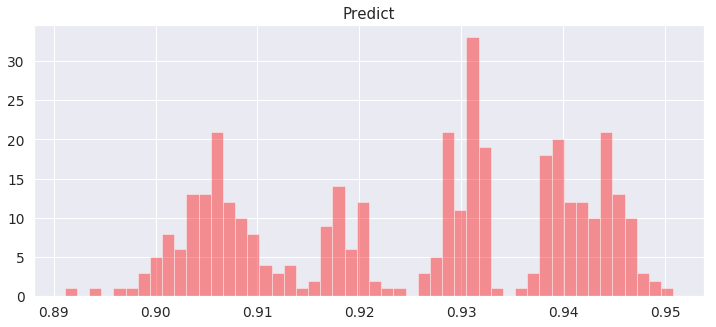

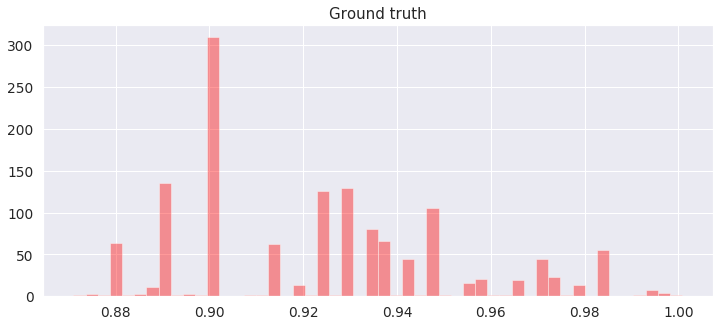

In [140]:
def result_plot(pred, truth):
    plt.figure(figsize=(12,5))
    sns.distplot(pred, bins=50, kde=False, color="red")
    plt.title("Predict")
    # plt.xlabel('yield', fontsize=12)
    plt.show()
    plt.figure(figsize=(12,5))
    sns.distplot(truth, bins=50, kde=False, color="red")
    plt.title("Ground truth")
    plt.show()
    
Y_pred = model.predict(X_train[1000:])
result_plot(Y_pred, y_train)

## xgb

In [141]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.422932	valid_data-rmse:0.423818
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.257049	valid_data-rmse:0.257767
[200]	train-rmse:0.156684	valid_data-rmse:0.157368
[300]	train-rmse:0.096187	valid_data-rmse:0.09678
[400]	train-rmse:0.059814	valid_data-rmse:0.060452
[500]	train-rmse:0.038085	valid_data-rmse:0.038818
[600]	train-rmse:0.025325	valid_data-rmse:0.026301
[700]	train-rmse:0.018003	valid_data-rmse:0.019486
[800]	train-rmse:0.013947	valid_data-rmse:0.016074
[900]	train-rmse:0.01175	valid_data-rmse:0.014514
[1000]	train-rmse:0.010546	valid_data-rmse:0.013829
[1100]	train-rmse:0.009853	valid_data-rmse:0.013559
[1200]	train-rmse:0.009414	valid_data-rmse:0.013455
[1300]	train-rmse:0.009093	valid_data-rmse:0.013419
[1400]	train-rmse:0.008837	valid_data-rmse:0.01341
[1500]	train-rmse:0.008618	valid_data-rmse:0.013439
[1600]	train-rmse:

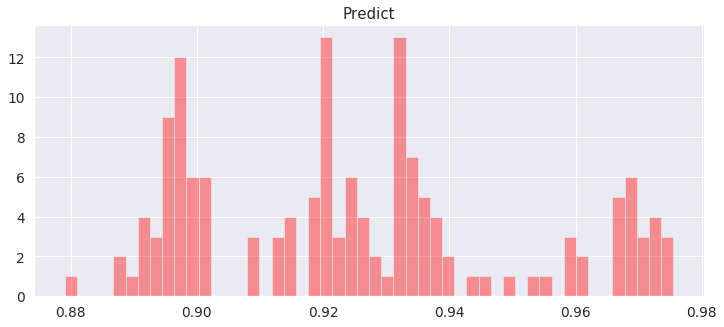

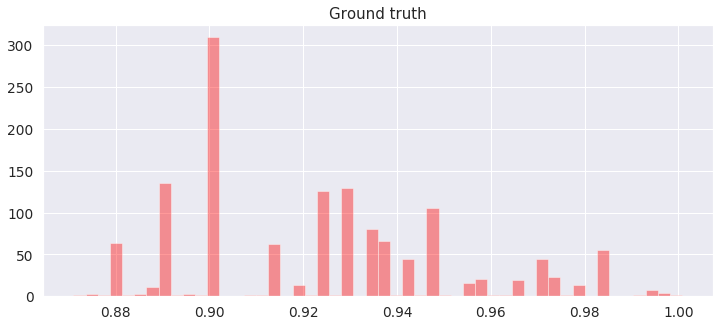

In [142]:
result_plot(predictions_xgb, y_train)